In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import pylab as pp
import numpy as np
import scipy as sp

import os
import datetime
import random

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score,mean_squared_error

# imports required by WindowGenerator_RUL.timeseries_dataset_from_array method
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util.tf_export import keras_export


# loading the formated datasets

In [3]:
trainData = []
testData = []
RUL = []

for i in range(1,5):
    trainData.append( pd.read_csv(('train_FD00%d_smooth.csv' % i),
                                  sep=' ',
                                  index_col=(0,1),
                                  header = 0,
                                  decimal='.',
                                  engine='python'))
    testData.append(pd.read_table(('test_FD00%d_smooth.csv' % i),
                                  sep=' ',
                                  index_col=(0,1),
                                  header = 0,
                                  decimal='.',
                                  engine='python'))
    RUL.append(pd.read_table(('RUL_FD00%d.txt' % i),
                             sep=' ',
                             index_col=False,
                             names=['RULtime'],
                             header = None,
                             engine='python'))

#  metadata from file readme.txt
FD001 = {"Data Set Name": "FD001",
         "idx" : 0,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD002 = {"Data Set Name": "FD002",
         "idx" : 1,
         "Train trjectories:": 260,
         "Test trajectories:" : 259,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 1,
         "Fault Modes name": "HPC Degradation"}

FD003 = {"Data Set Name": "FD003",
         "idx" : 2,
         "Train trjectories:": 100,
         "Test trajectories:" : 100,
         "Conditions": 1,
         "Conditions name" : "Sea Level",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

FD004 = {"Data Set Name": "FD004",
         "idx" : 3,
         "Train trjectories:": 249,
         "Test trajectories:" : 248,
         "Conditions": 6,
         "Conditions name" : "",
         "Fault Modes": 2,
         "Fault Modes name": ["HPC Degradation", "Fan Degradation"]}

metadata = [FD001,FD002,FD003,FD004]


* data are loaded in the Pandas DataFrames
* each DF contains data from the whole file
* DF has multiindex consisting of unit and time

* The datasets are organized in two separate lists, one for training datasets, second for the test datasets.
* Unlike the original datasets, each formated dataset contain a header row with names of columns in the first row.
* The time is in cycles, counting from the last cycle recorded cycle in each trajectory. I.e. in the case of train data, the time represents the remaining useful lifetime, RUL.

## a quick peak at the smoothed and formated data FD001

In [4]:
# dataset index
meta = FD001

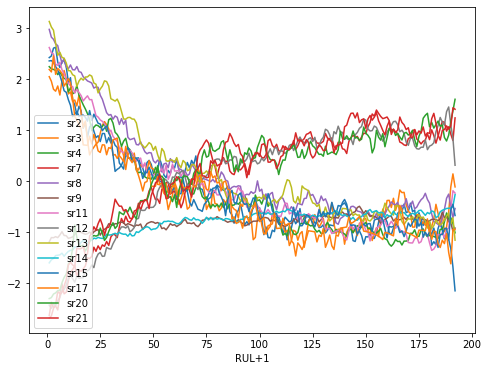

In [5]:

trainData[meta['idx']].loc[1,'sr2':].plot();

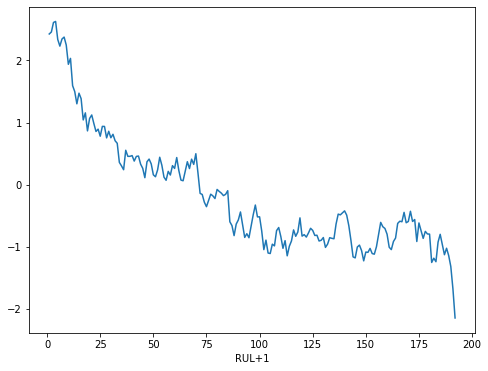

In [6]:
trainData[meta['idx']].loc[1,'sr2'].plot()

The data show typical wear curve, elbow point from where the fault develops exponentially

# data reduction with PCA

In [7]:
train_data = trainData[meta['idx']].loc[:,'sr2':] # include only the sensor readings in the PCA, not the op's

## applying the PCA on the sensor readings in whole training dataset
# Make an instance of the Model
pca = PCA(.97)
pca.fit(train_data)
print(pca.n_components_)

3


Four PCs are needed to explain more than 97% of the variance. 

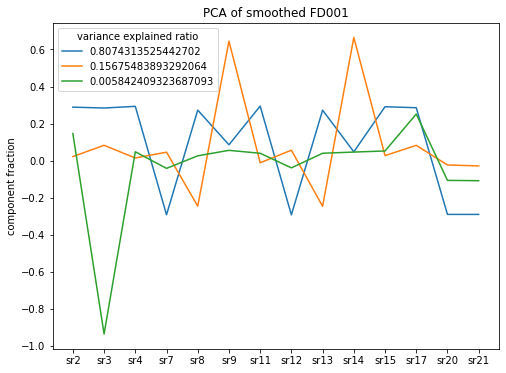

In [8]:
pp.plot(pca.components_.T,)
pp.legend(pca.explained_variance_ratio_,title='variance explained ratio');
pp.xticks(np.arange(0, len(train_data.columns), 1), train_data.columns)
pp.ylabel('component fraction');
pp.title('PCA of smoothed ' + meta['Data Set Name']) ;

The PCA characterize the two modes of fault:

* there are 4 significant PCs: listed in order of decreasing explanied variance ratio: PC1 (54%), PC2 (35 %), PC3 (6 %) and PC4 (2%)

* the green-curve PCA with about 6% expl. var. resemble the fault mode observed in the data set FD001
* unsure about the requirement for the 2% EV PC. we'll see from the transformed trajectories

In [9]:
# Apply PCA transform to both the training set and the test set.
train_data = pca.transform(train_data)
test_data = testData[meta['idx']].loc[:,'sr2':]
test_data = pca.transform(test_data)

In [10]:
print(test_data. shape, train_data.shape)

(13096, 3) (20631, 3)


### Couple the op data with the transformed sensor readings - the pcs:

In [11]:
train_dataPD = pd.DataFrame(index=trainData[meta['idx']].index,columns=['op1','op2','pc1','pc2','pc3'])
train_dataPD.loc[:,'op1':'op2'] = trainData[meta['idx']].loc[:,'op1':'op2']
train_dataPD.loc[:,'pc1':'pc4'] = train_data

test_dataPD = pd.DataFrame(index=testData[meta['idx']].index,columns=['op1','op2','pc1','pc2','pc3'])
test_dataPD.loc[:,'op1':'op2'] = testData[meta['idx']].loc[:,'op1':'op2']
test_dataPD.loc[:,'pc1':'pc4'] = test_data


In [12]:
train_dataPD.head()

op1     op2      pc1      pc2       pc3
unit RUL+1                                            
1    1      0.0009      -0  8.44646 -2.99692   0.12002
     2          -0 -0.0004  8.24125 -2.85737  0.161138
     3     -0.0027  0.0001  8.21954 -2.78722  0.396669
     4     -0.0006  0.0002  7.90839 -2.68465  0.314726
     5     -0.0067  0.0003  7.66528 -2.59677  0.175683

In [13]:
test_dataPD.head()

op1     op2      pc1       pc2        pc3
unit time                                              
1    1    -0.0006  0.0004  -2.7973 -0.909398  0.0642624
     2    -0.0025  0.0004 -2.81804   -0.9508  -0.232398
     3     0.0014  0.0001 -2.82512 -0.905257  -0.273284
     4     0.0022  0.0005 -2.72793 -0.890267  -0.243098
     5    -0.0007  0.0001 -2.88372 -0.992663  0.0652853

# look at the operational parameters

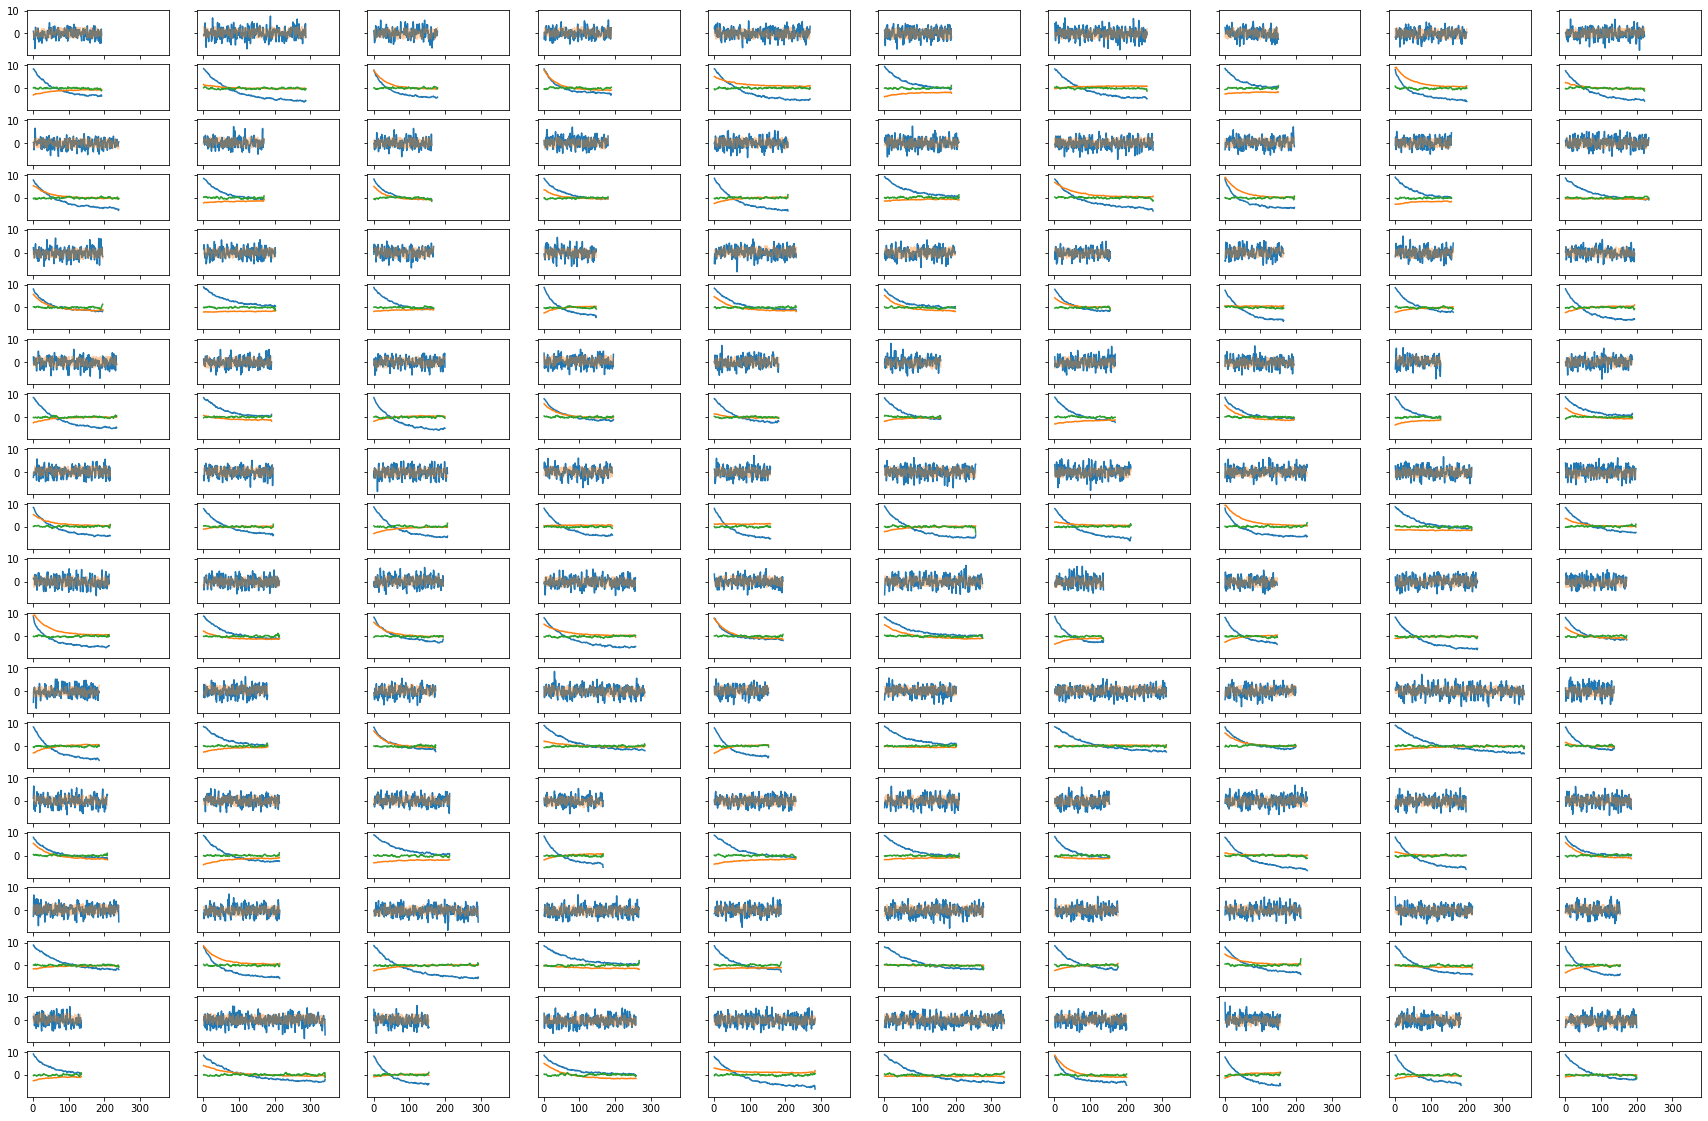

In [14]:
nrows=10
ncols=10
fig, ax = pp.subplots(figsize=(30,20),nrows=2*nrows, ncols=ncols, sharex=True, sharey=True,)
#ax=ax.flatten()
for traj_jdx in range (0,nrows,1):
    for traj_idx in range(0,ncols,1): 
        #operational parameters on every even row
        row=traj_jdx*2
        col=traj_idx
        ax[row,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'op1']*1000)
        ax[row,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'op2']*5000,alpha=0.4)
        # PC of the sensor readings on the every odd row
        ax[row+1,col].plot(train_dataPD.loc[ncols*traj_jdx+traj_idx+1,'pc1':'pc4'])
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc2'],alpha=0.8)
        #ax[traj_jdx+1,traj_idx].plot(train_dataPD.loc[traj_jdx/2+traj_idx+1,'pc3'],alpha=0.6)
        

Observations:
* The operation conditions for all the trajectories are more-or less equal in all trajectories.
* The first PC does  always terminate at around 10, This is evidently the  fault mode given in the data description. 
    * the first mode is characterized by first PC that terminates at value of about 10. In those cases, this PC dominates throughout the trajectory.
  

# machine learning pipeline:
    * use only pc1 to estimate the RUL

# try the Recurrent Neural Network

the training function

In [16]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        shuffle=False,
                        callbacks=[early_stopping])
    return history

# create the window generator for RUL labels

### format the datasets to contain RUL as a last feature for training purposes

In [17]:

train_dataPD['RUL'] = train_dataPD.index.get_level_values(level='RUL+1') - 1

test_dataPD['RUL'] = test_dataPD.index.get_level_values(level='time') - 1
for trajectory in test_dataPD.index.get_level_values(level='unit').unique():
    base = test_dataPD.loc[trajectory,'RUL'].values
    test_dataPD.loc[trajectory,'RUL'] = base + RUL[meta['idx']].iloc[trajectory-1].values[0]
    pass

In [18]:
test_dataPD.head()

op1     op2      pc1       pc2        pc3  RUL
unit time                                                   
1    1    -0.0006  0.0004  -2.7973 -0.909398  0.0642624  112
     2    -0.0025  0.0004 -2.81804   -0.9508  -0.232398  113
     3     0.0014  0.0001 -2.82512 -0.905257  -0.273284  114
     4     0.0022  0.0005 -2.72793 -0.890267  -0.243098  115
     5    -0.0007  0.0001 -2.88372 -0.992663  0.0652853  116

In [19]:
train_dataPD.head()

op1     op2      pc1      pc2       pc3  RUL
unit RUL+1                                                 
1    1      0.0009      -0  8.44646 -2.99692   0.12002    0
     2          -0 -0.0004  8.24125 -2.85737  0.161138    1
     3     -0.0027  0.0001  8.21954 -2.78722  0.396669    2
     4     -0.0006  0.0002  7.90839 -2.68465  0.314726    3
     5     -0.0067  0.0003  7.66528 -2.59677  0.175683    4

In [20]:
fm = 0 # fault mode 
val_idx = 1 # integer index of the trajectory within its fault mode category
test_idx = 4 
train_idx = 3
signals = ['pc1','pc2','pc3','RUL'] # adding the RUL as the last feature to faciliate the training and eval

test_df = test_dataPD.loc[test_idx,signals]
val_df = test_dataPD.loc[val_idx,signals]
train_df = train_dataPD.loc[train_idx,signals]



C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


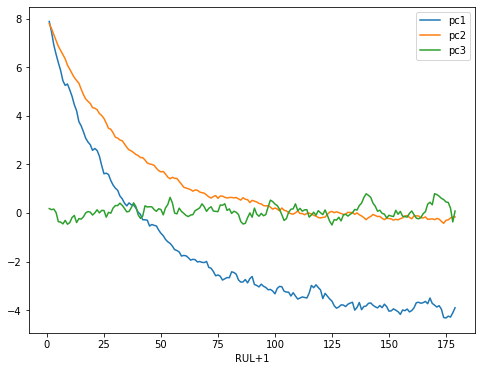

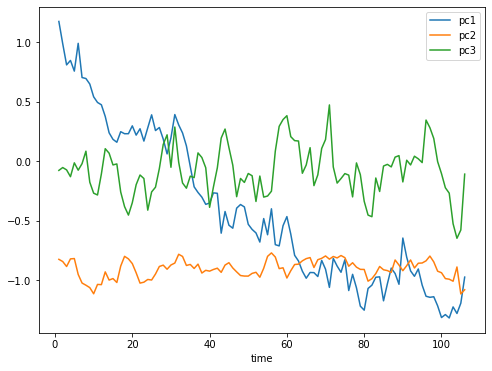

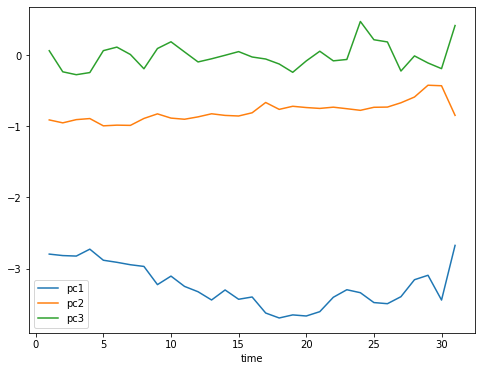

In [21]:
train_df.loc[:,'pc1':'pc3'].plot()
pp.axes()
test_df.loc[:,'pc1':'pc3'].plot()
pp.axes()
val_df.loc[:,'pc1':'pc3'].plot()

## The window generator for trajectory time series

In [22]:
# generate windows to feed the model during training
class WindowGenerator_RUL():
    def __init__(self, input_width, label_width=1, shift=0,
               train_df=None, val_df=None, test_df=None,
               label_columns=None,
               batch_size=32,drop_remainder=True):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        # Work out prognostic features:
        self.prognostic_columns = []
        if label_columns is not None:
            for col_name in train_df.columns:
                if col_name not in label_columns: # use only columns that are NOT label as input
                    self.prognostic_columns.append(col_name)
                else:
                    pass
        else: 
            self.prognostic_columns = train_df.columns # if no label_columns are given use all columns in input
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.drop_remainder = drop_remainder

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        #self.label_start = self.total_window_size - self.label_width
        self.label_start = 0 # use only one label, that is in the first index
        self.labels_slice = slice(self.label_start, self.label_width)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.prognostic_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    def plot(self, model=None, plot_col='RUL', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} ')
            
            label_col_index = -1

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('time')
    def plot_RUL(self, model=None, plot_col='RUL'):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        #max_n = min(max_subplots, len(inputs))
        #plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} ')

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        plt.scatter(range(len(inputs)), labels[:, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(range(len(inputs)), predictions[:, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        
        plt.legend()

        plt.xlabel('sample')
    def plot_RUL_RNN(self, model=None, plot_col='RUL'):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        #max_n = min(max_subplots, len(inputs))
        #plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col}')

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        plt.scatter(range(len(inputs)), labels[:, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(range(len(inputs)), predictions[ :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        
        plt.legend()

        plt.xlabel('sample')
    def sequences_from_indices(self,array, indices_ds, start_index, end_index):
      dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
      dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
          lambda steps, inds: array_ops.gather(steps, inds),  # pylint: disable=unnecessary-lambda
          num_parallel_calls=dataset_ops.AUTOTUNE)
      return dataset
    #@keras_export('keras.preprocessing.timeseries_dataset_from_array', v1=[])
    def timeseries_dataset_from_array(self,
        data,
        targets,
        sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
      """Creates a dataset of sliding windows over a timeseries provided as array.

      This function takes in a sequence of data-points gathered at
      equal intervals, along with time series parameters such as
      length of the sequences/windows, spacing between two sequence/windows, etc.,
      to produce batches of timeseries inputs and targets.

      Arguments:
        data: Numpy array or eager tensor
          containing consecutive data points (timesteps).
          Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
          It should have same length as `data`. `targets[i]` should be the target
          corresponding to the window that starts at index `i`
          (see example 2 below).
          Pass None if you don't have target data (in this case the dataset will
          only yield the input data).
        sequence_length: Length of the output sequences (in number of timesteps).
        sequence_stride: Period between successive output sequences.
          For stride `s`, output samples would
          start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
          within sequences. For rate `r`, timesteps
          `data[i], data[i + r], ... data[i + sequence_length]`
          are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
          (except maybe the last one).
        shuffle: Whether to shuffle output samples,
          or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
          than `start_index` will not be used
          in the output sequences. This is useful to reserve part of the
          data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
          will not be used in the output sequences.
          This is useful to reserve part of the data for test or validation.

      Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.

      Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,  sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:

      ```
      First sequence:  [0  2  4  6  8 10 12 14 16 18]
      Second sequence: [3  5  7  9 11 13 15 17 19 21]
      Third sequence:  [6  8 10 12 14 16 18 20 22 24]
      ...
      Last sequence:   [78 80 82 84 86 88 90 92 94 96]
      ```

      In this case the last 3 data points are discarded since no full sequence
      can be generated to include them (the next sequence would have started
      at index 81, and thus its last step would have gone over 99).

      Example 2: temporal regression. Consider an array `data` of scalar
      values, of shape `(steps,)`. To generate a dataset that uses the past 10
      timesteps to predict the next timestep, you would use:

      ```python
      input_data = data[:-10]
      targets = data[10:]
      dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          input_data, targets, sequence_length=10)
      for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])  # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])  # Corresponding target: step 10
        break
      ```
      """
      # Validate the shape of data and targets
      if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                         'time steps (axis 0) but got '
                         'shape(data) = %s; shape(targets) = %s.' %
                         (data.shape, targets.shape))
      if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                         'length of the data. Got: start_index=%s '
                         'for data of length %s.' % (start_index, len(data)))
      if end_index:
        if start_index and end_index <= start_index:
          raise ValueError('end_index must be higher than start_index. Got: '
                           'start_index=%s, end_index=%s.' %
                           (start_index, end_index))
        if end_index >= len(data):
          raise ValueError('end_index must be lower than the length of the data. '
                           'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
          raise ValueError('end_index must be higher than 0. '
                           'Got: end_index=%s' % (end_index,))


      # Validate strides
      if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
            'sampling_rate must be higher than 0 and lower than '
            'the length of the data. Got: '
            'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
      if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
            'sequence_stride must be higher than 0 and lower than '
            'the length of the data. Got: sequence_stride=%s '
            'for data of length %s.' % (sequence_stride, len(data)))


      if start_index is None:
        start_index = 0
      if end_index is None:
        end_index = len(data)


      # Determine the lowest dtype to store start positions (to lower memory usage).
      num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
      if num_seqs < 2147483647:
        index_dtype = 'int32'
      else:
        index_dtype = 'int64'


      # Generate start positions
      start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
      if shuffle:
        if seed is None:
          seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)


      sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
      sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)


      positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()


      # For each initial window position, generates indices of the window elements
      indices = dataset_ops.Dataset.zip(
          (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
              lambda i, positions: math_ops.range(  # pylint: disable=g-long-lambda
                  positions[i],
                  positions[i] + sequence_length * sampling_rate,
                  sampling_rate),
              num_parallel_calls=dataset_ops.AUTOTUNE)


      dataset = self.sequences_from_indices(data, indices, start_index, end_index)
      if targets is not None:
        indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                lambda i, positions: positions[i],
                num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = self.sequences_from_indices(
            targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
      if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
      dataset = dataset.batch(batch_size,drop_remainder=self.drop_remainder)
      return dataset # timeseries_dataset_from_array
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        #ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        ds = self.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=False,
          batch_size=self.batch_size,
          )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result



In [23]:
window_width=30
batch_size=1
wide_window = WindowGenerator_RUL(
    input_width=window_width, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=batch_size)

wide_window

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [0]
Label column name(s): ['RUL']

In [24]:
single_step_window = WindowGenerator_RUL(
    input_width=1, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',])



## let's look at the generated windows

C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
C:\Users\rais\programs\Anaconda3_430\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

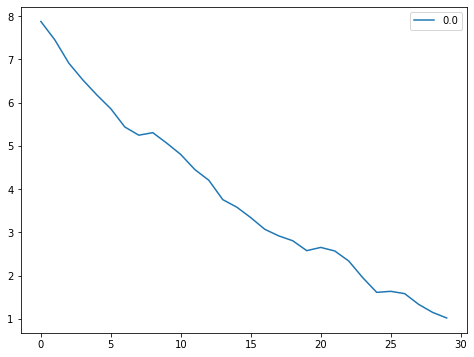

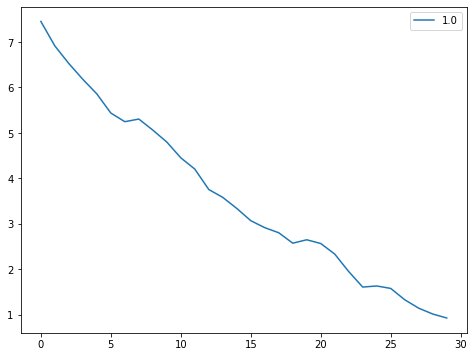

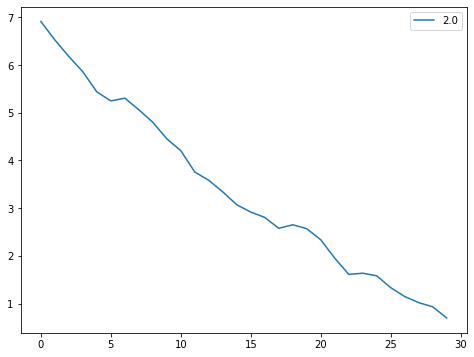

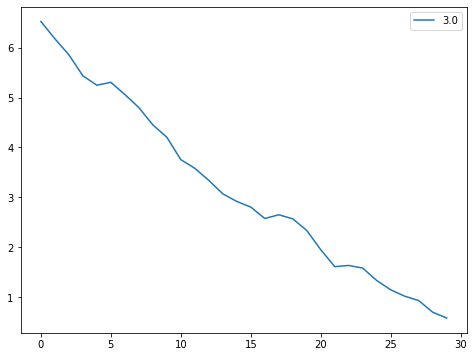

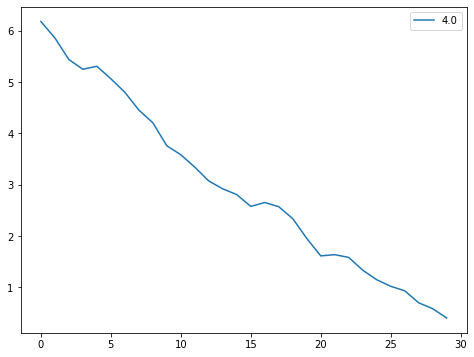

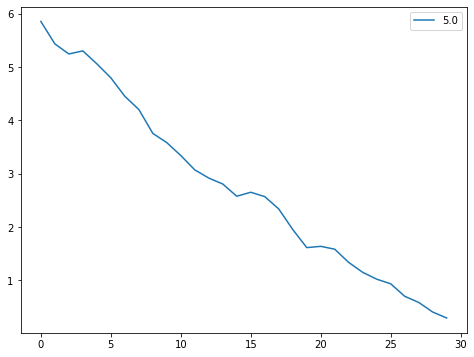

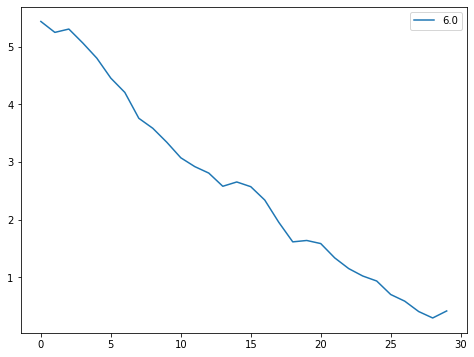

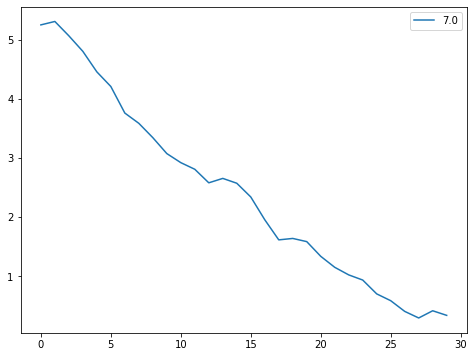

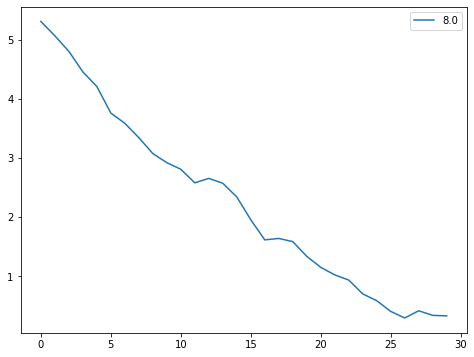

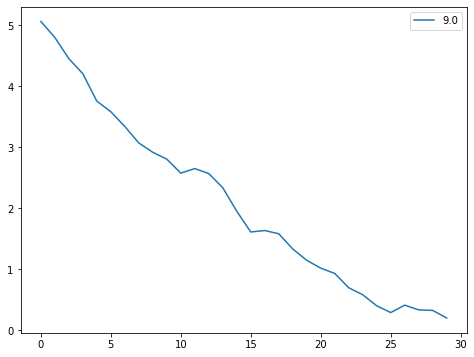

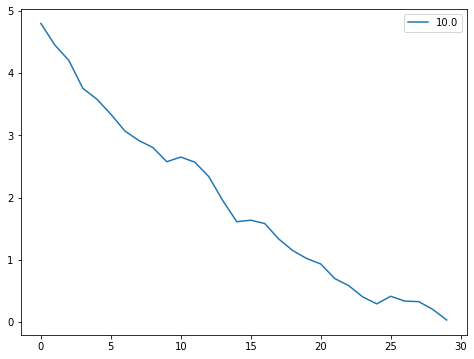

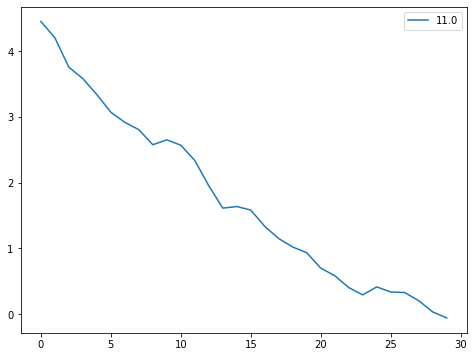

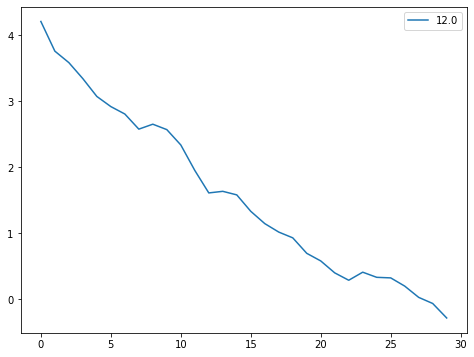

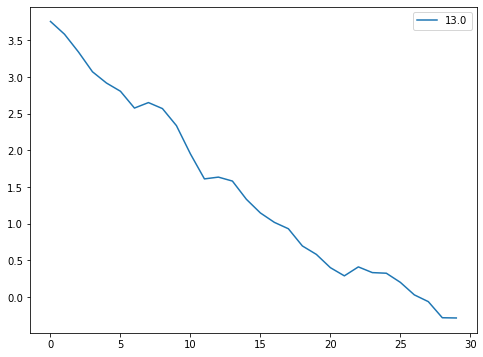

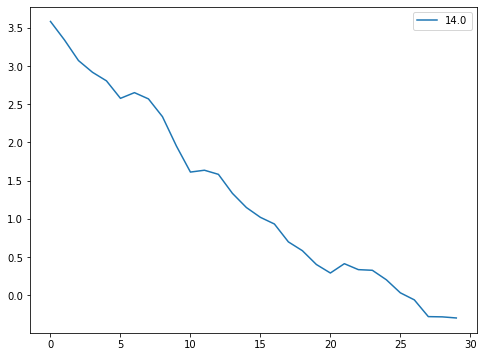

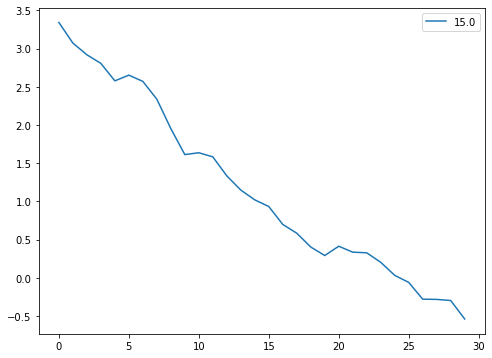

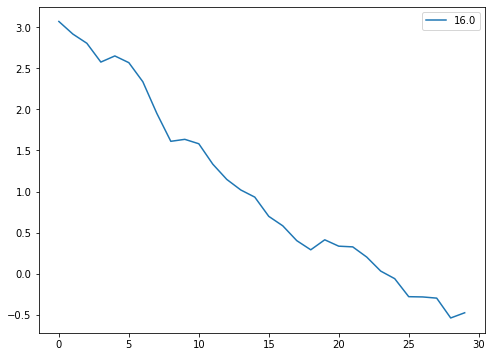

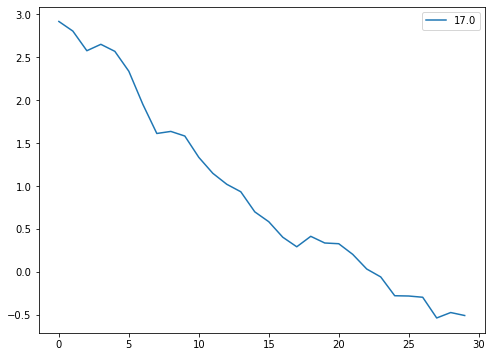

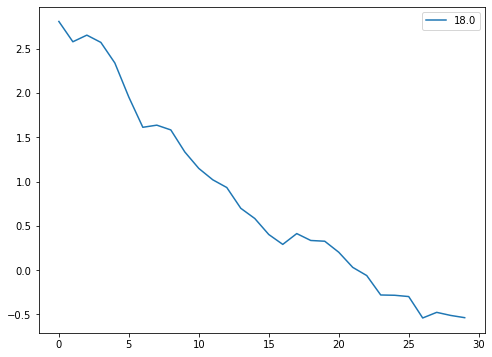

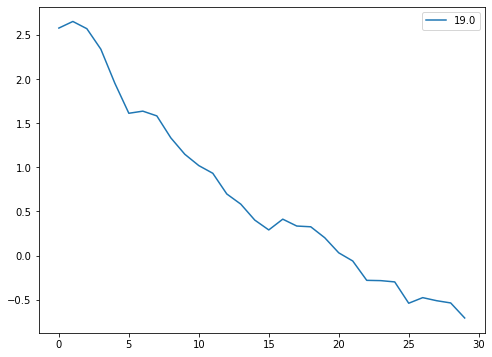

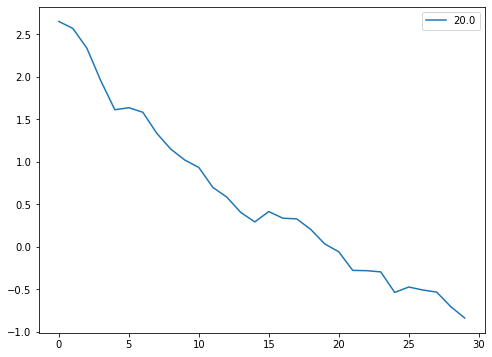

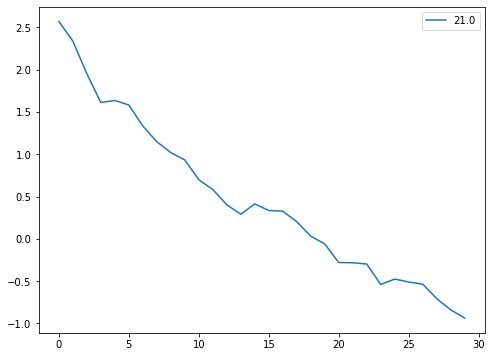

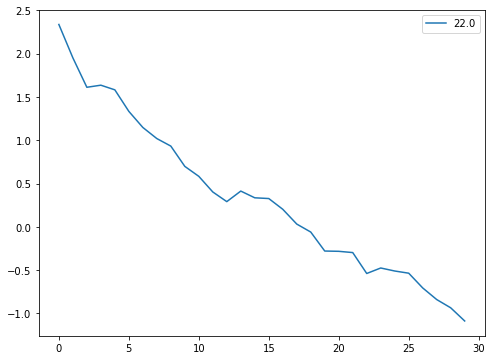

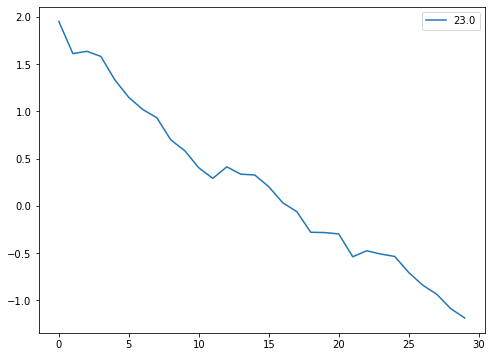

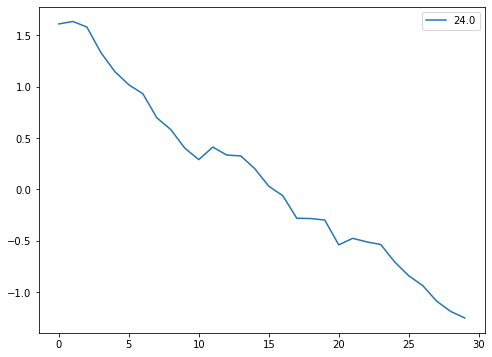

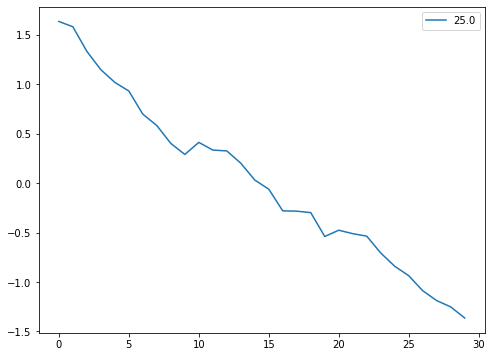

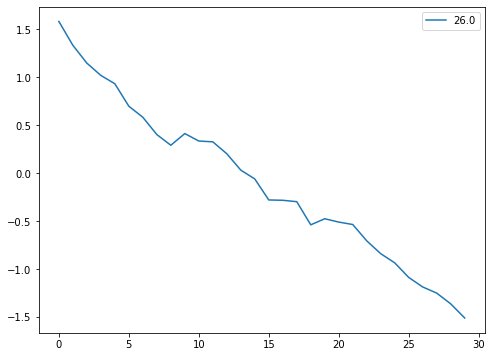

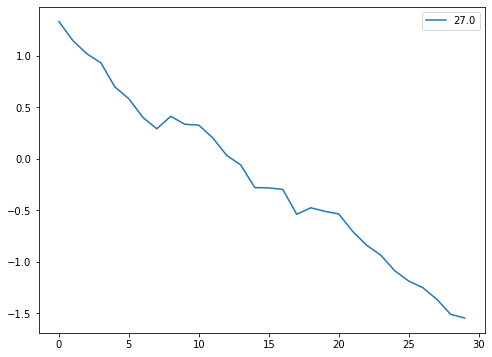

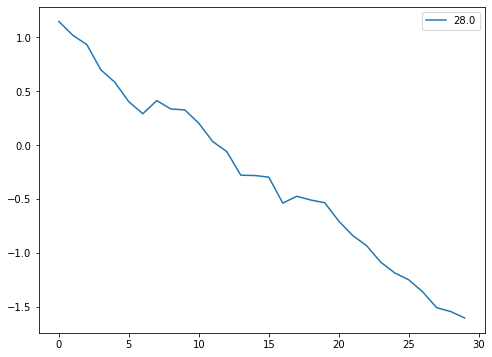

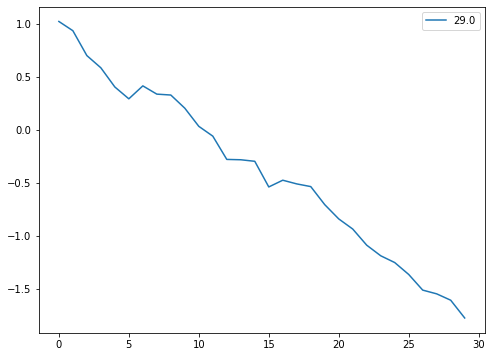

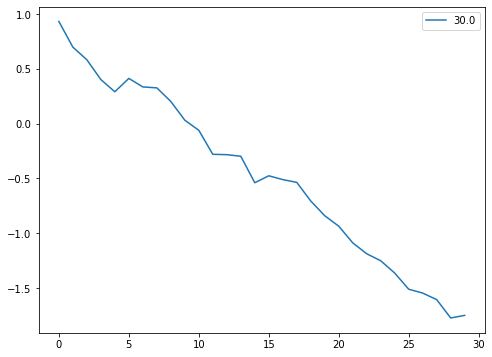

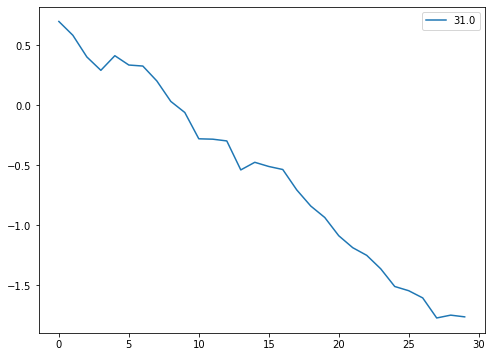

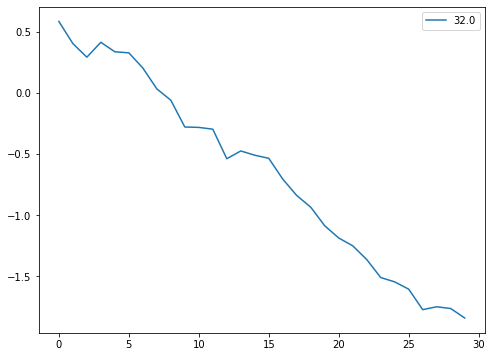

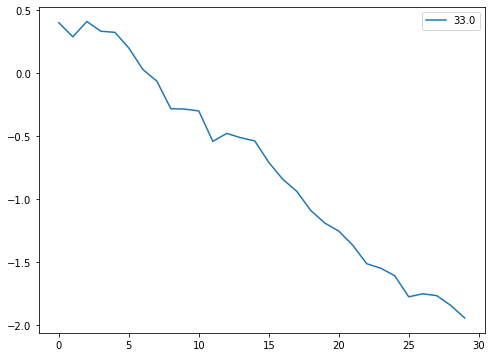

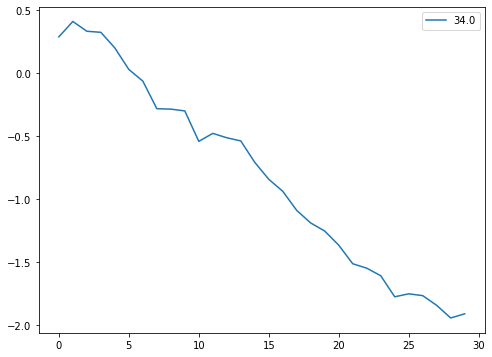

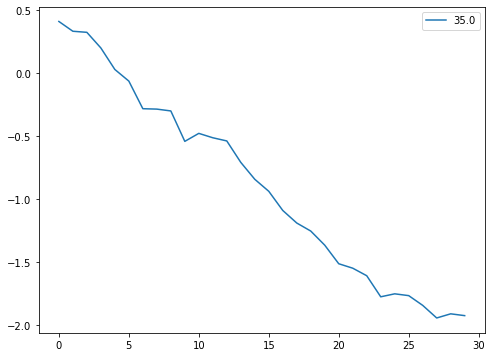

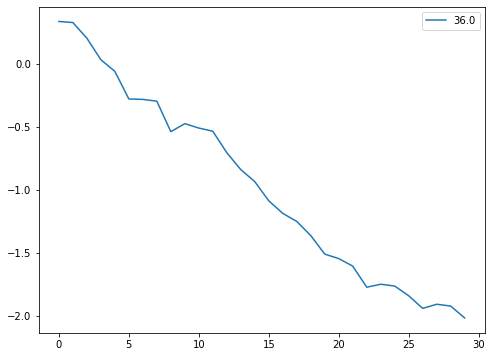

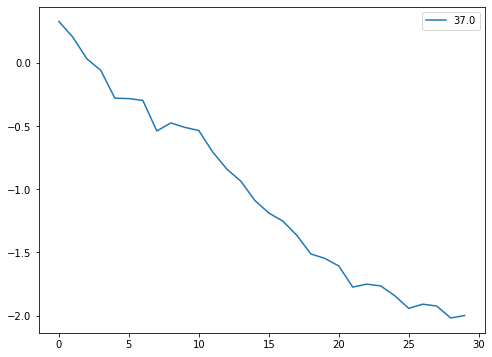

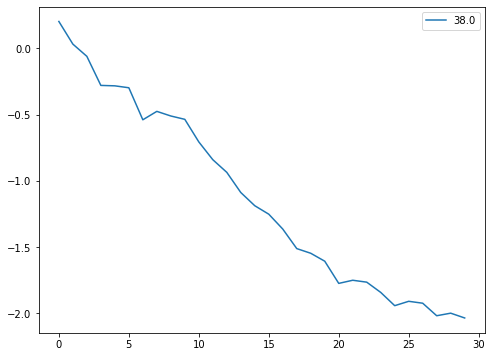

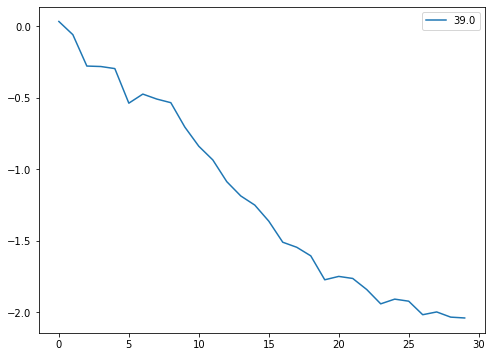

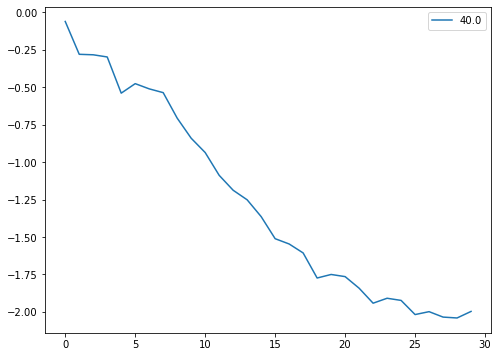

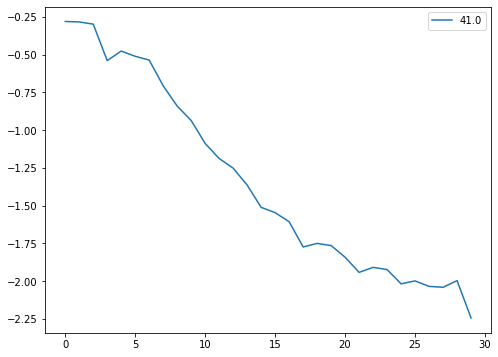

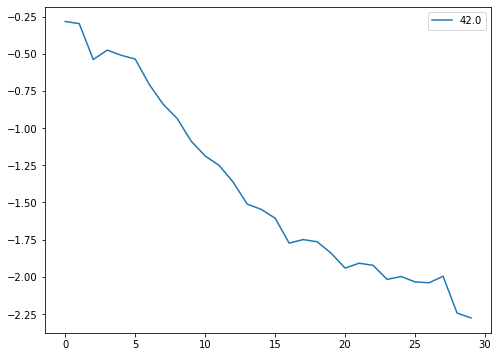

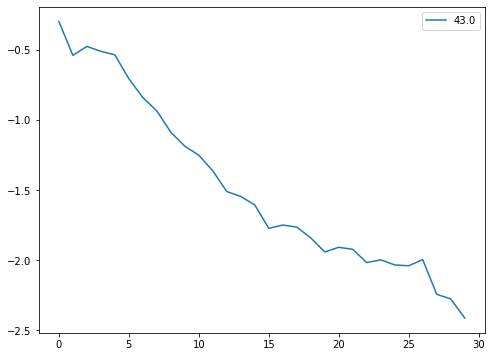

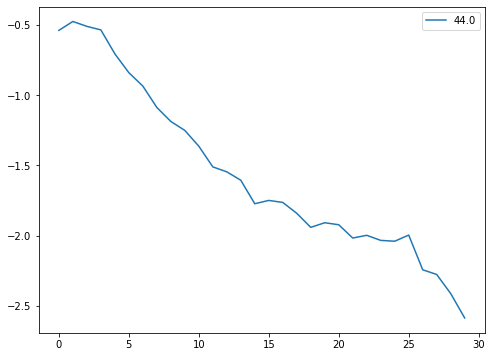

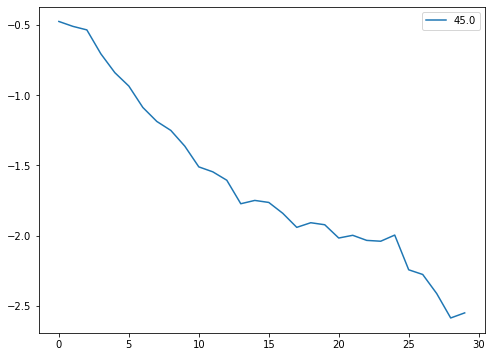

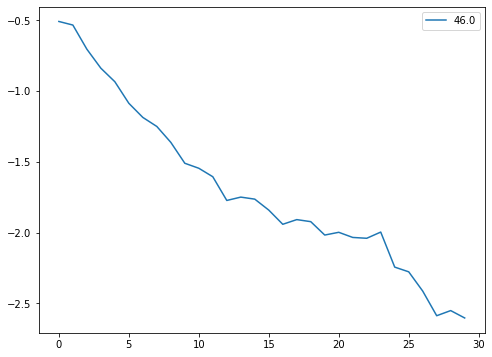

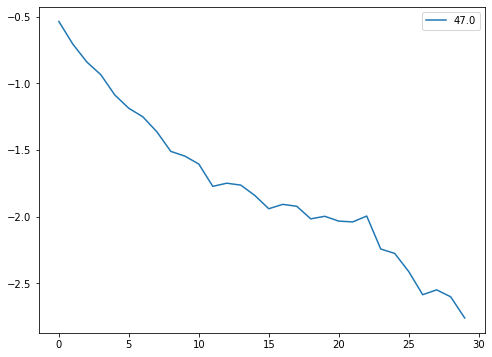

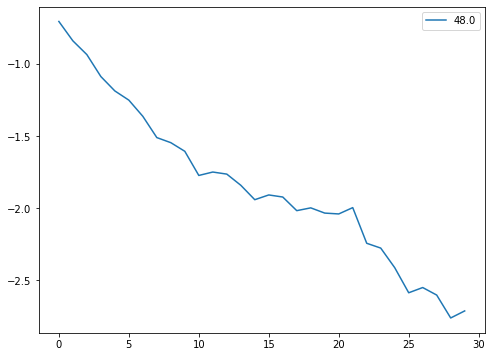

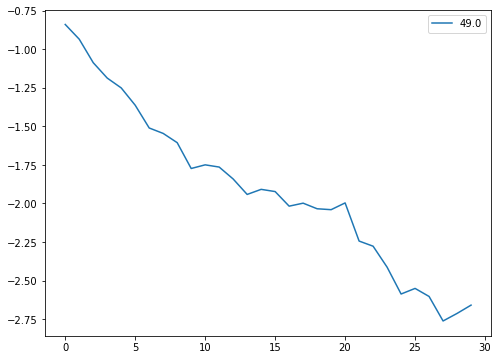

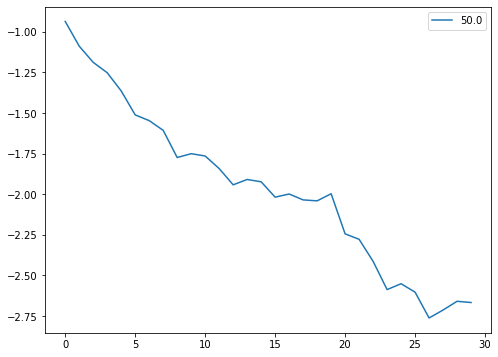

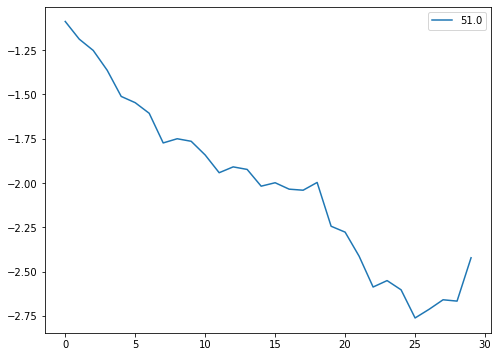

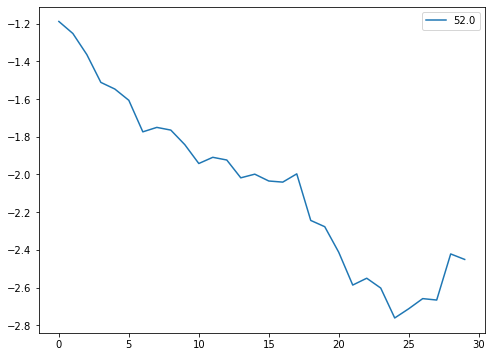

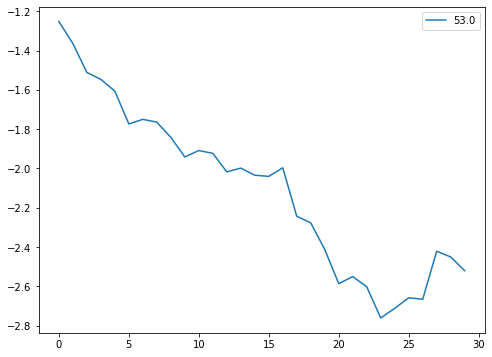

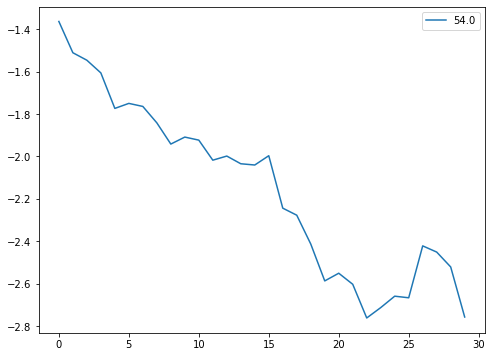

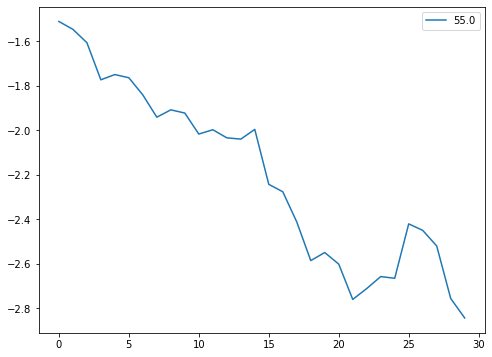

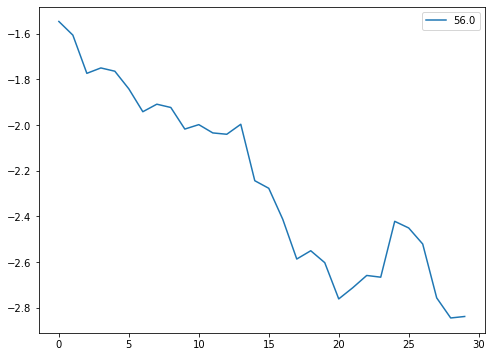

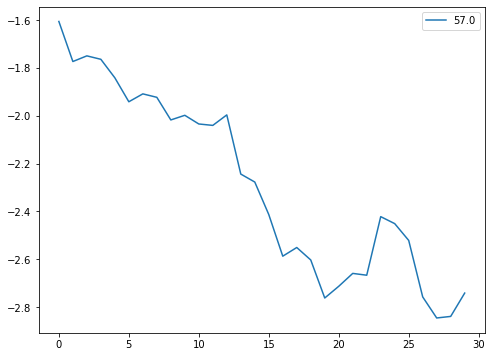

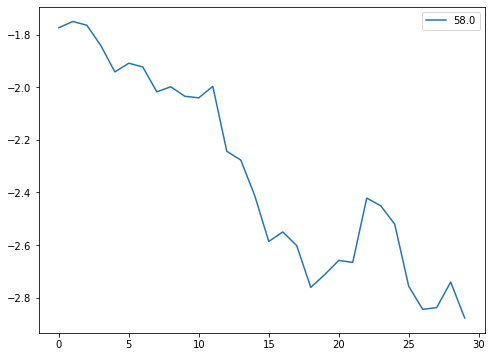

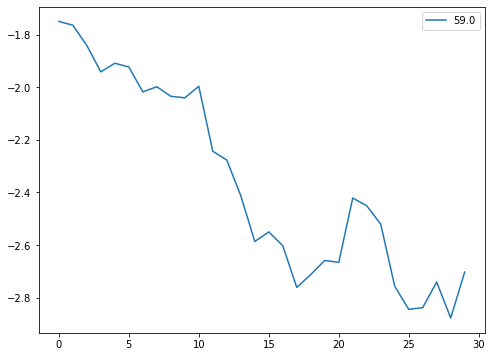

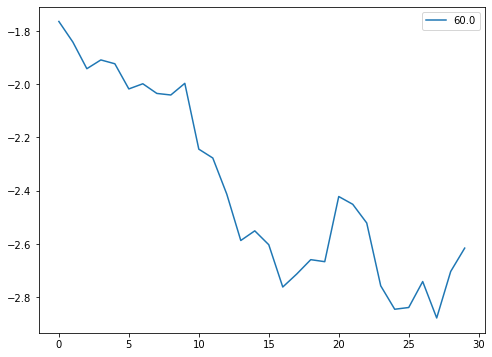

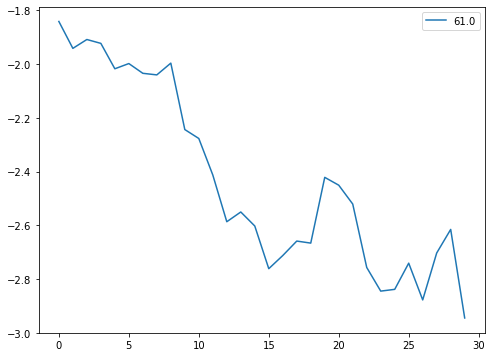

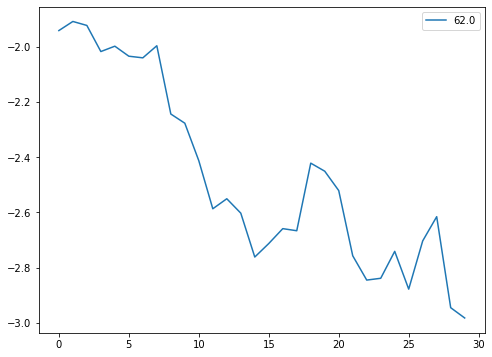

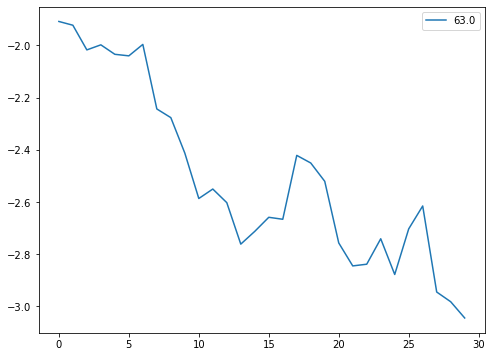

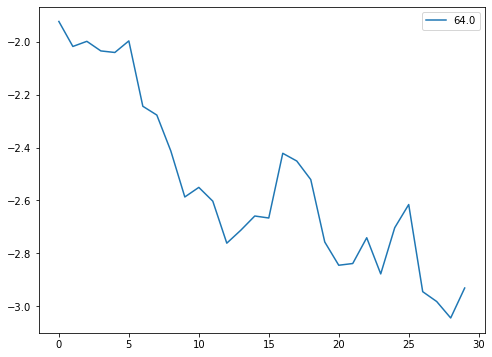

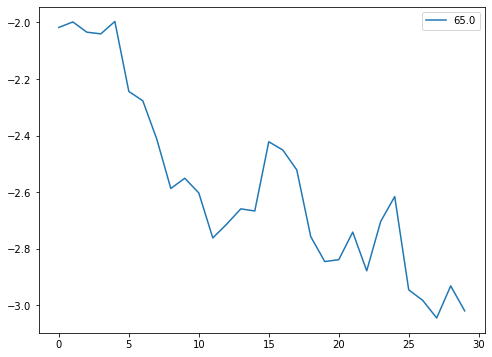

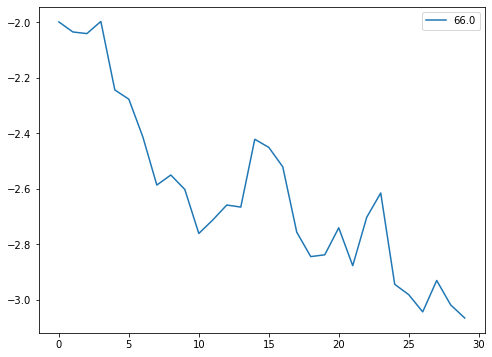

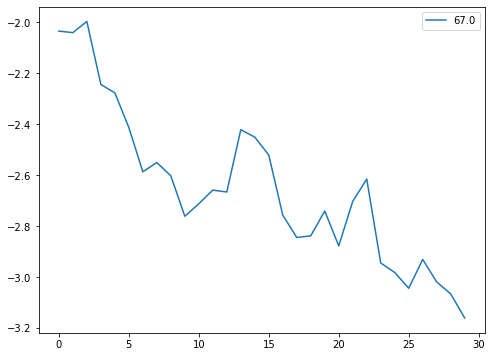

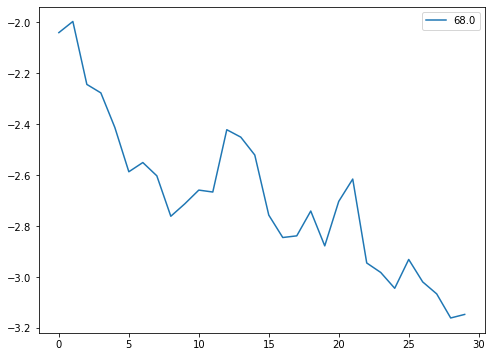

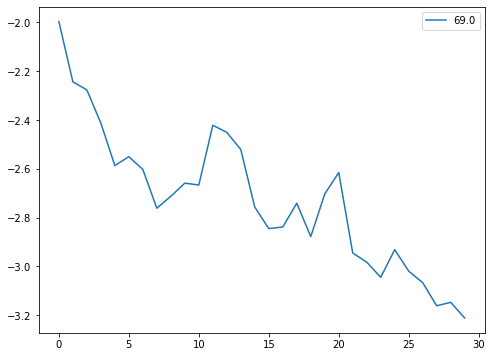

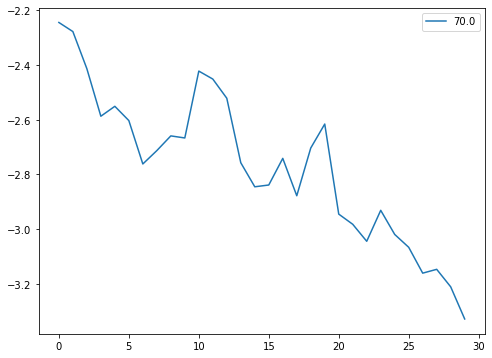

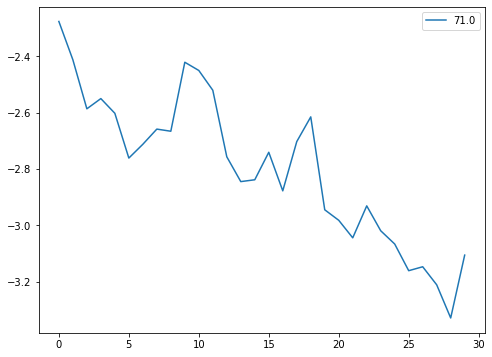

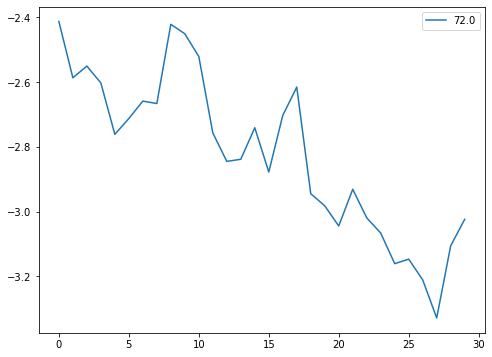

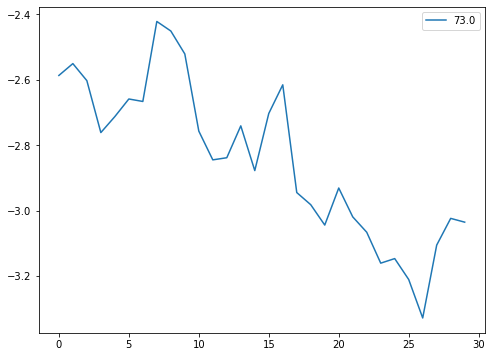

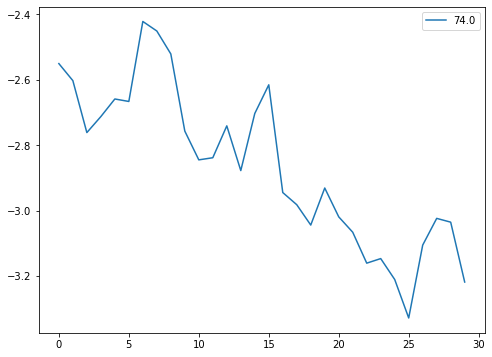

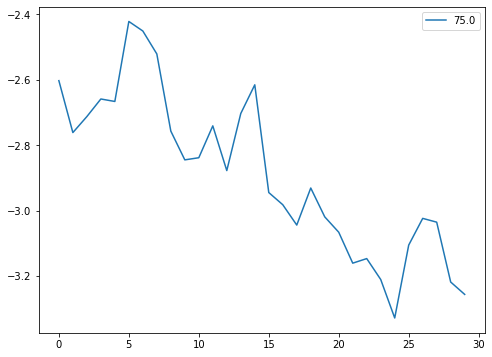

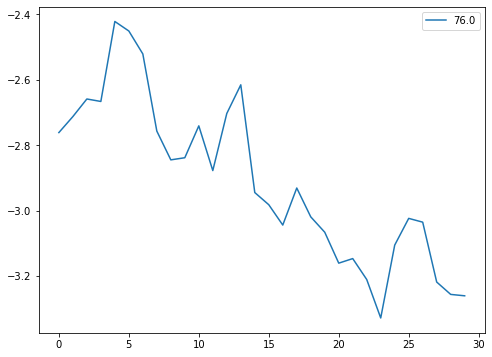

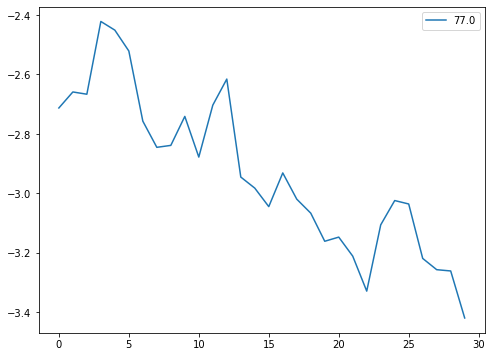

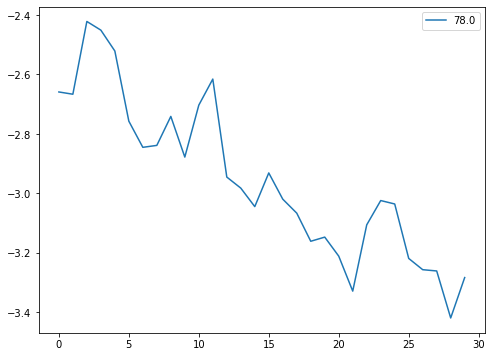

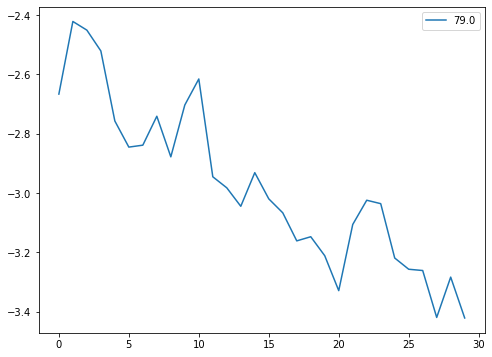

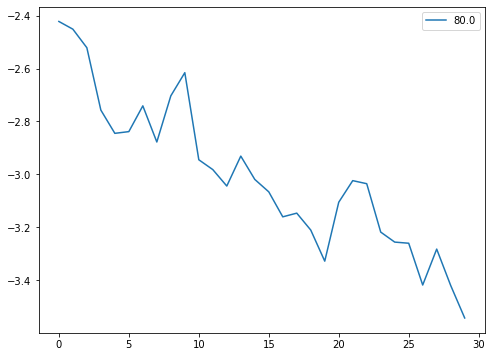

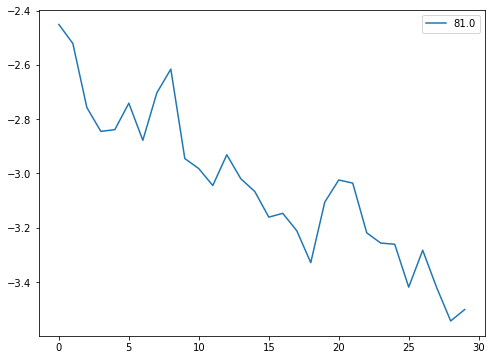

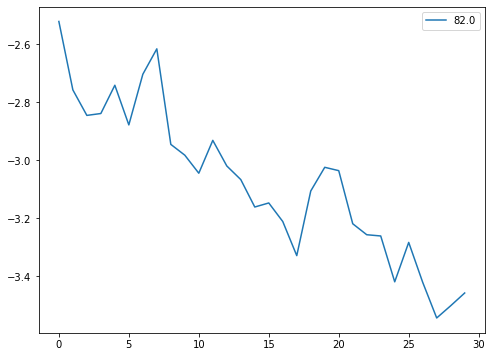

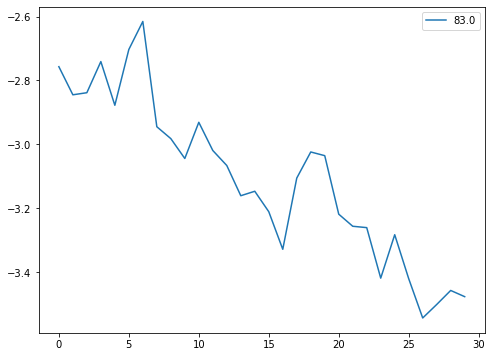

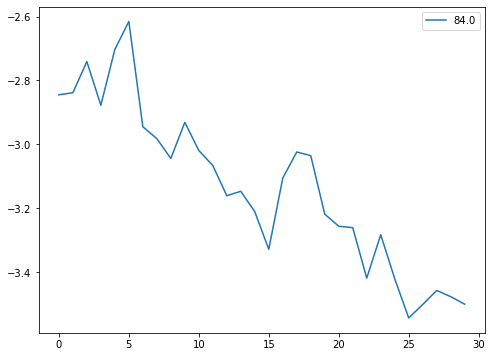

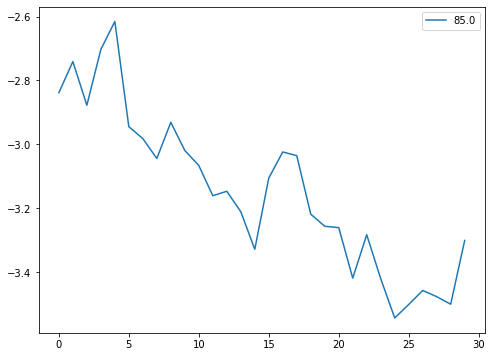

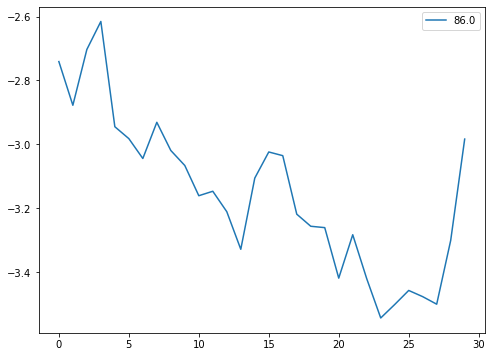

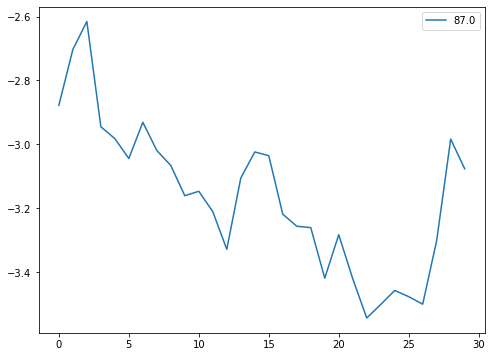

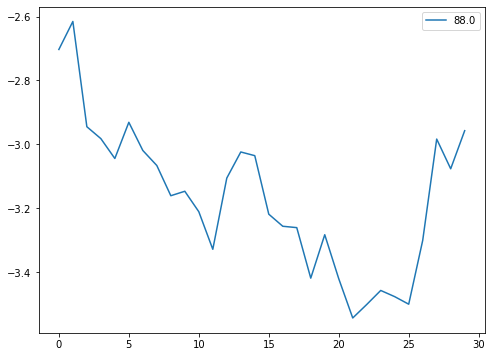

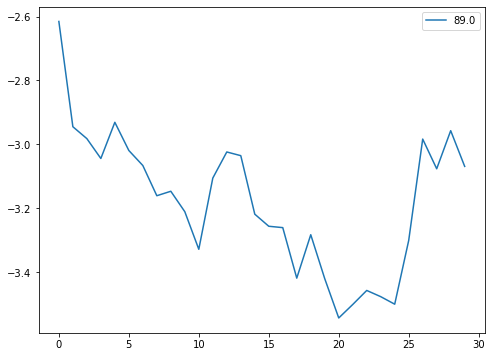

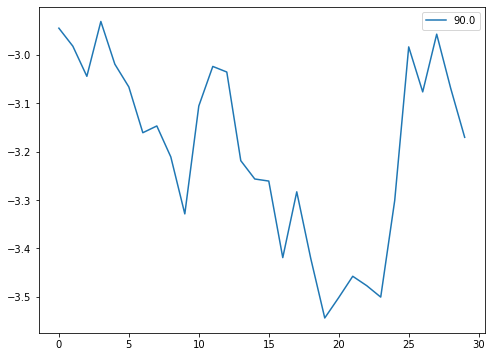

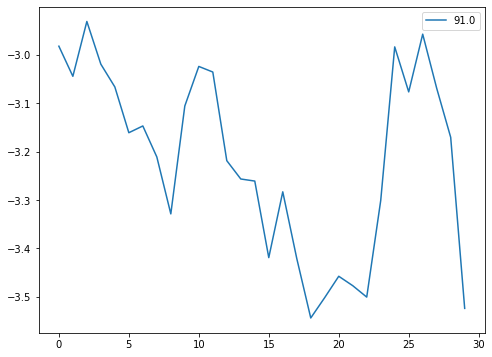

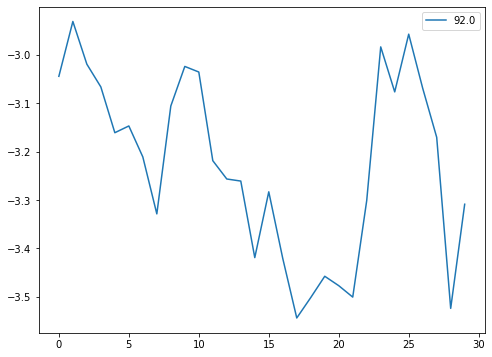

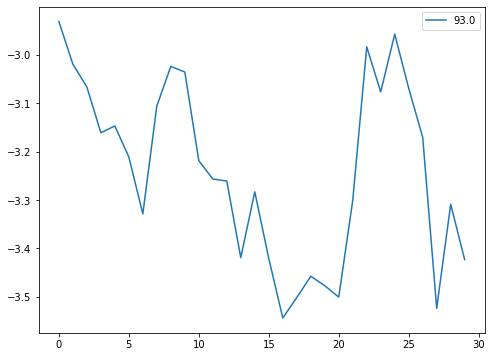

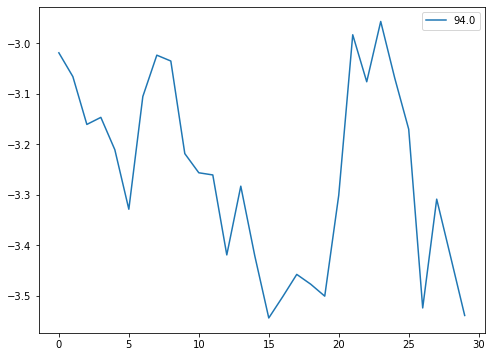

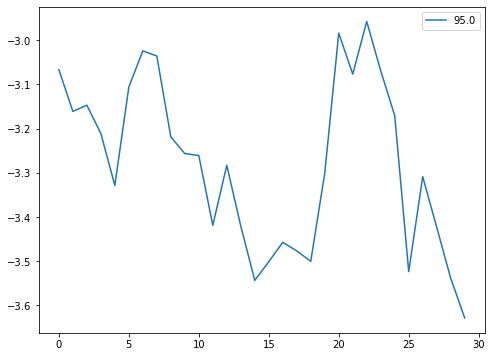

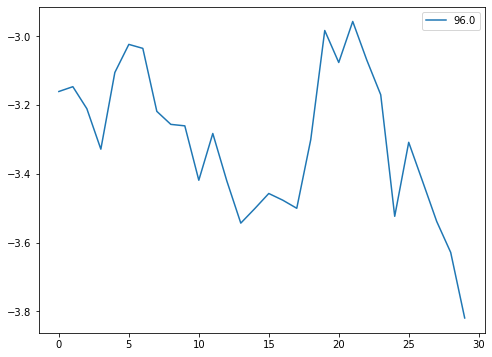

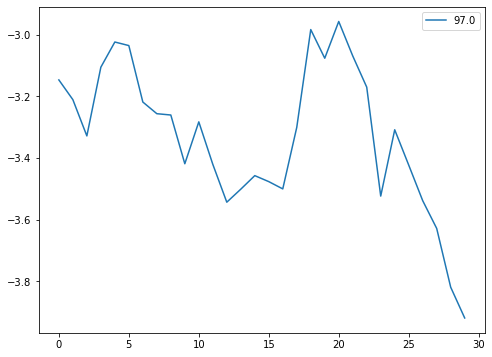

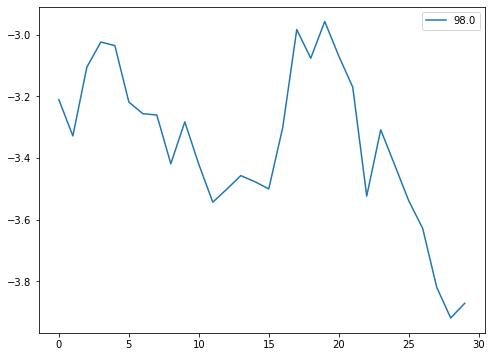

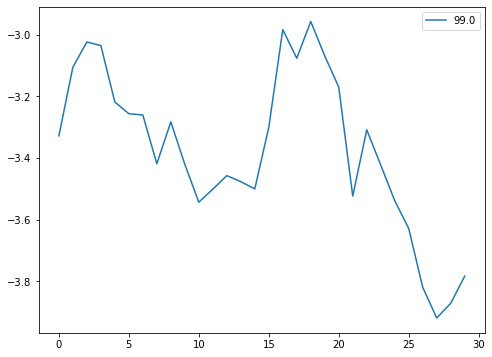

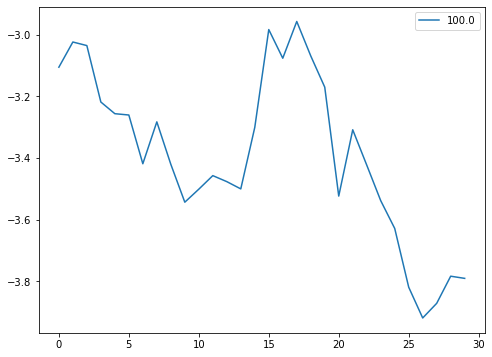

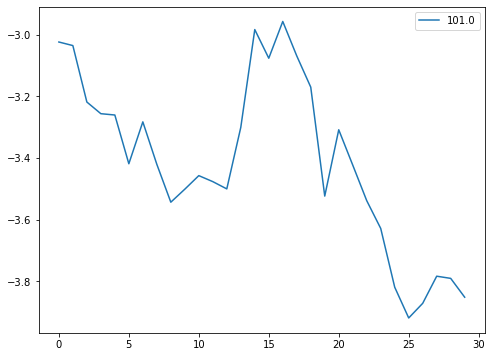

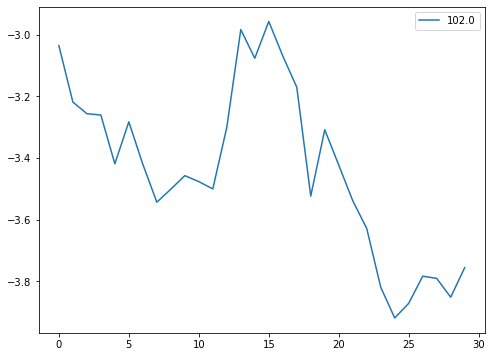

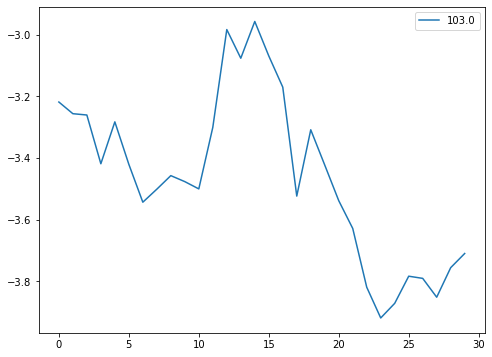

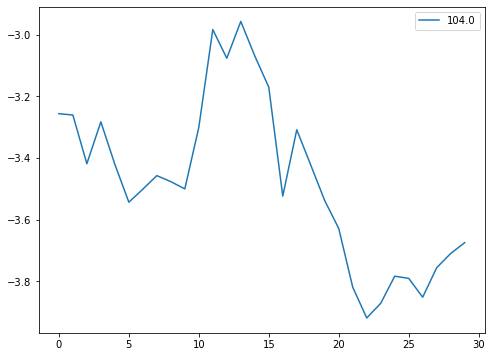

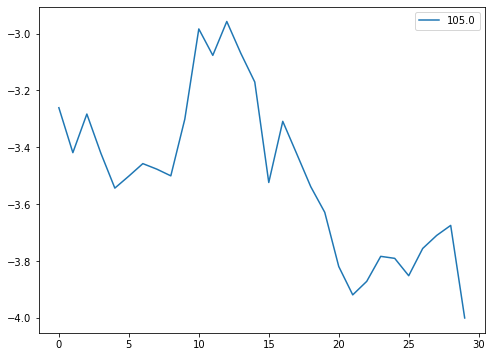

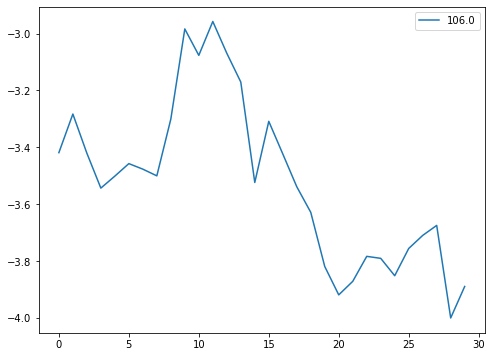

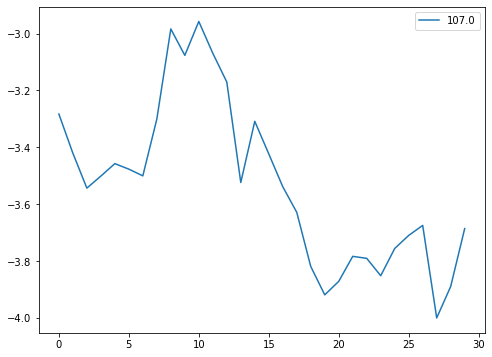

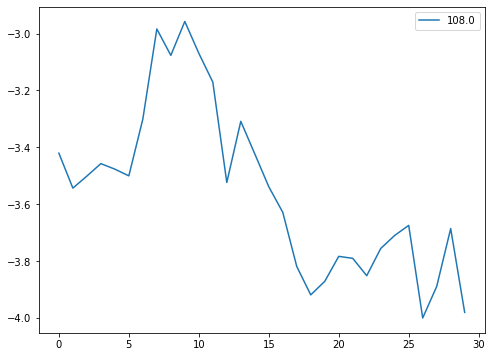

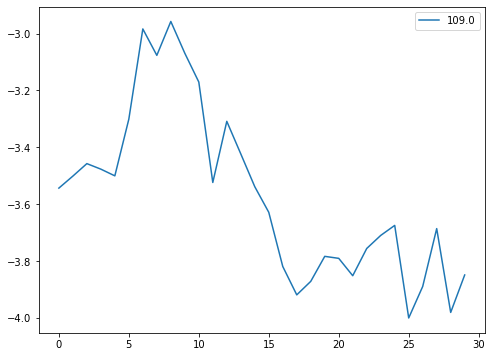

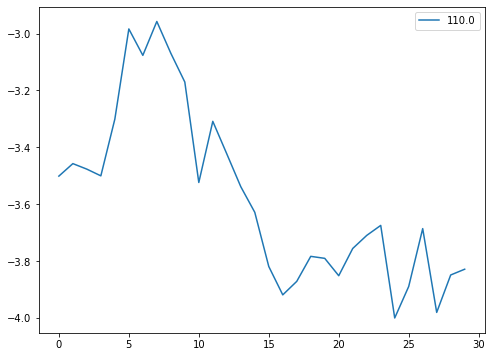

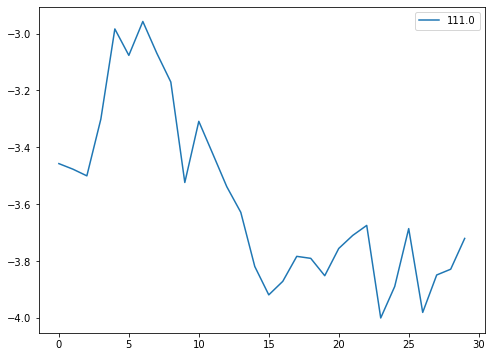

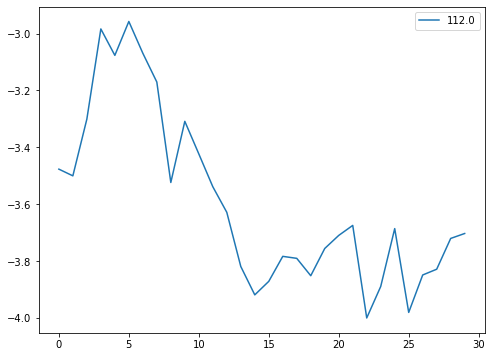

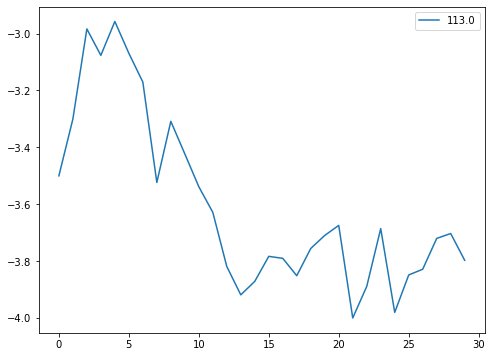

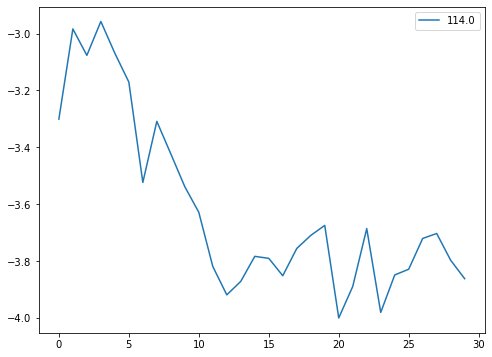

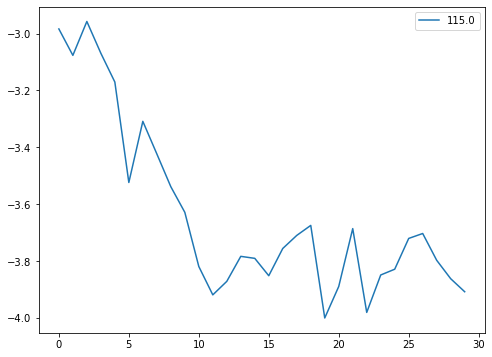

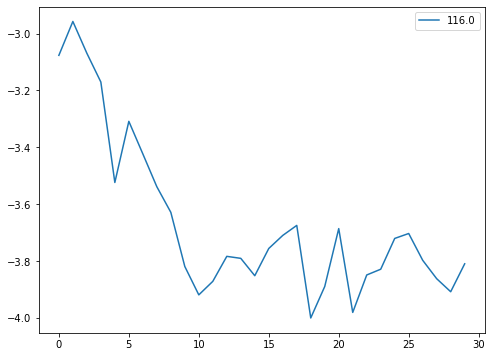

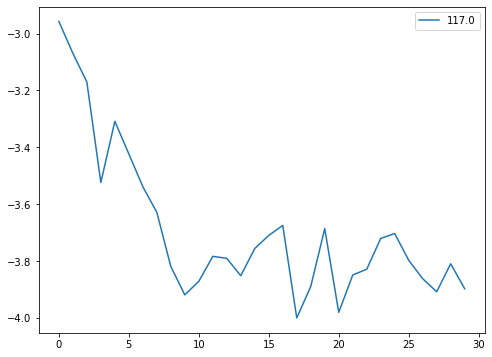

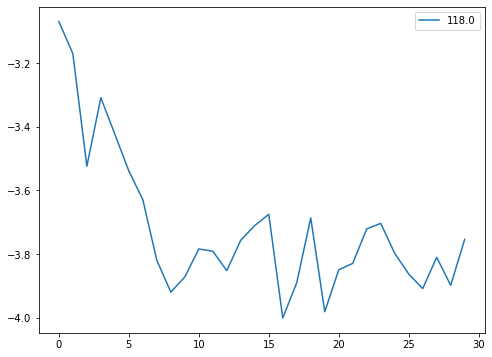

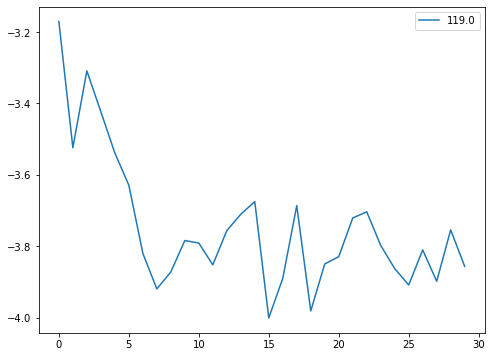

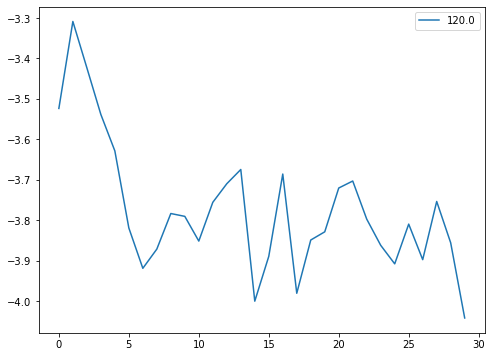

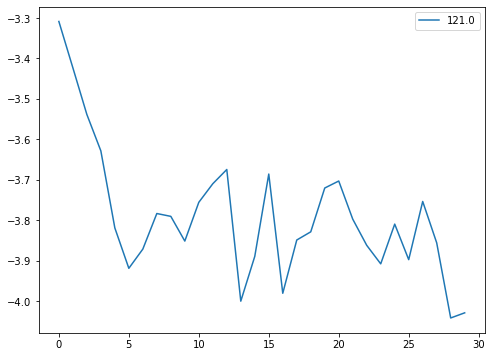

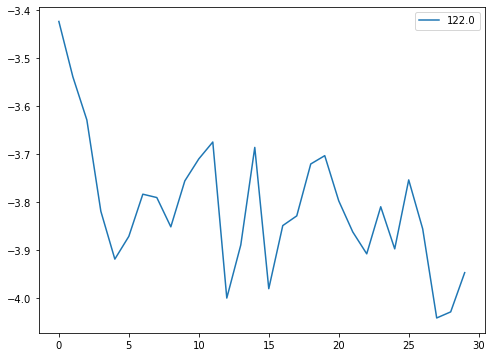

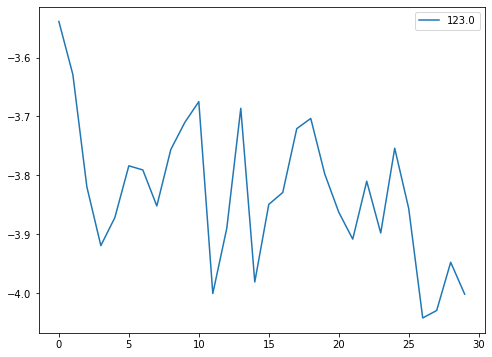

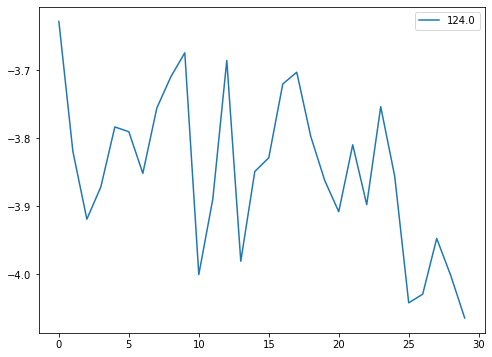

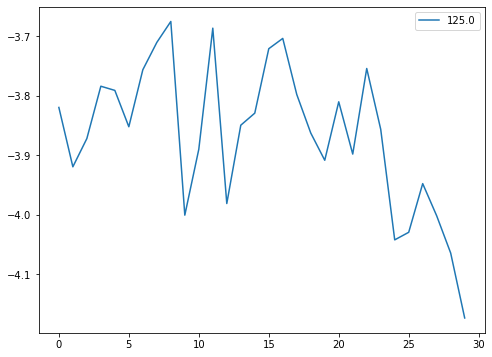

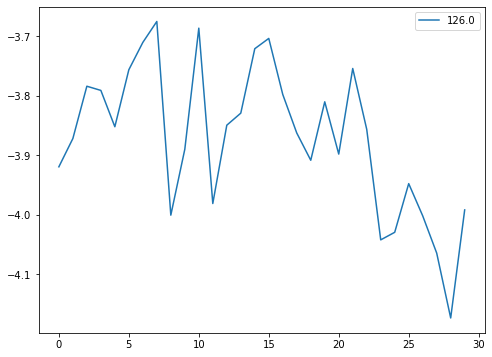

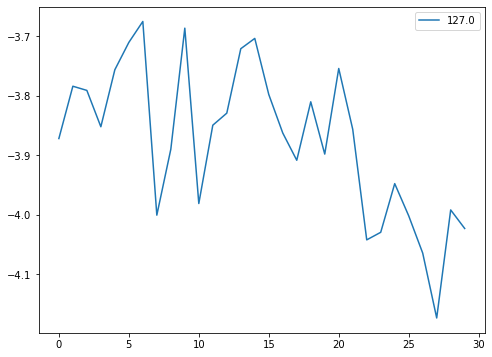

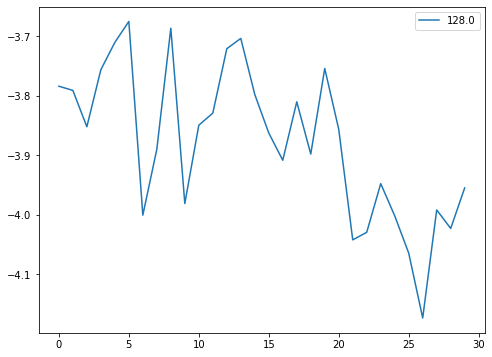

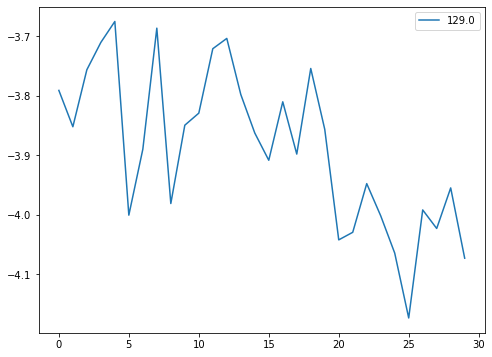

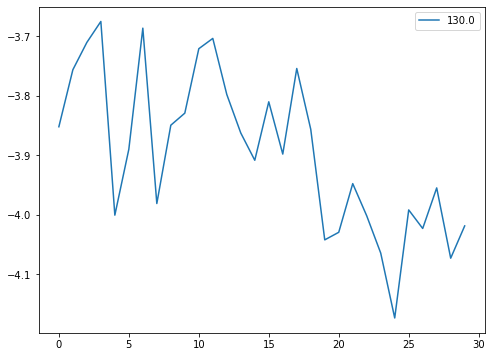

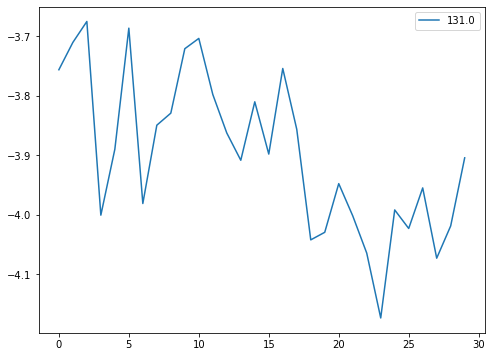

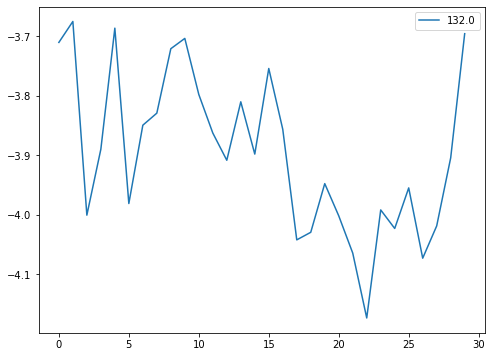

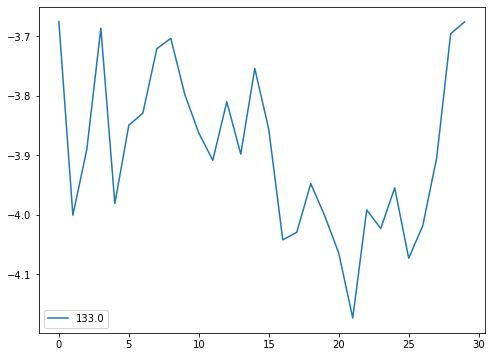

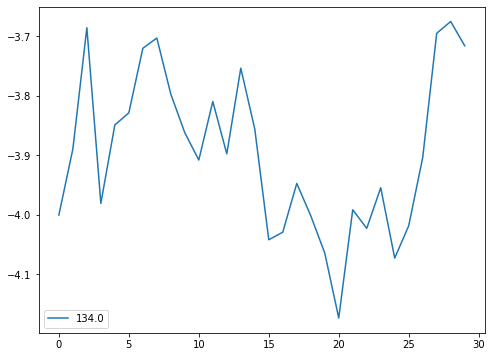

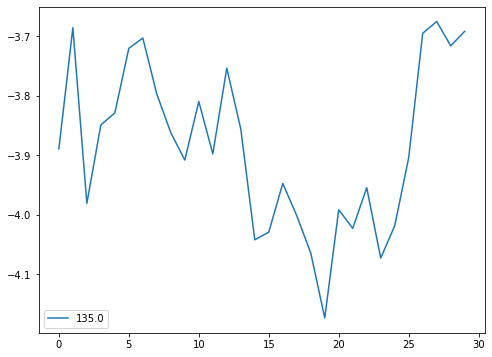

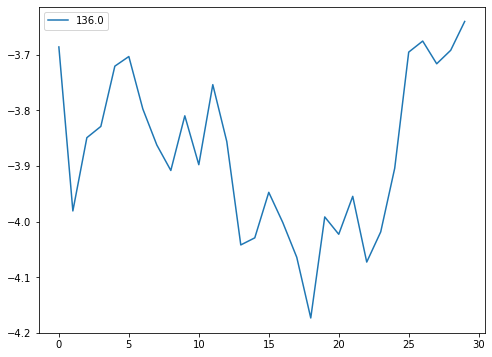

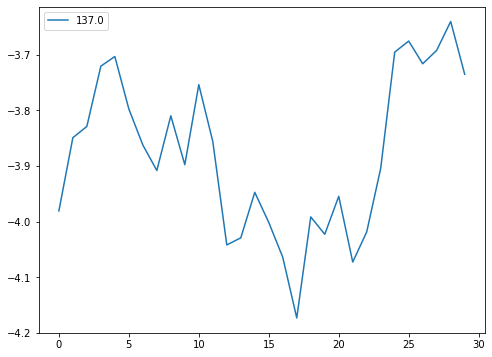

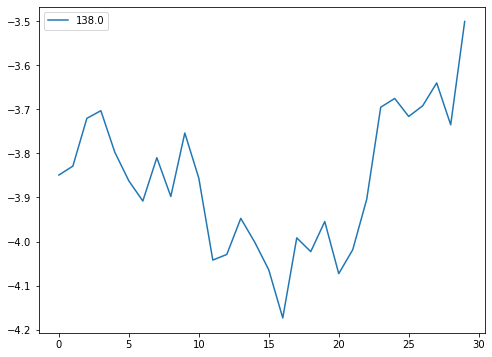

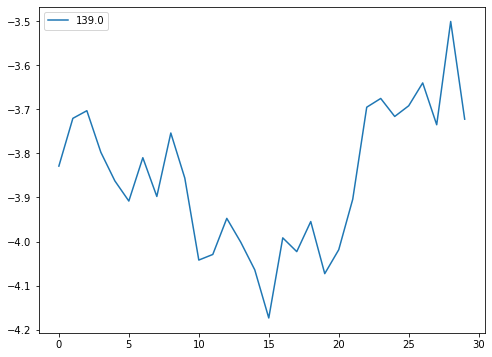

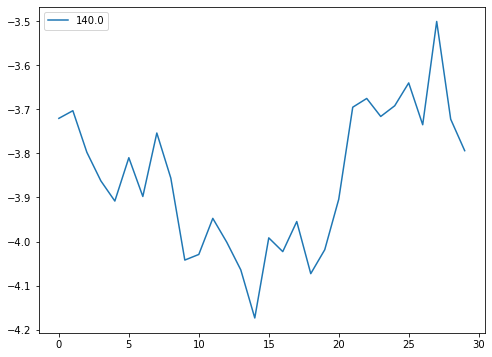

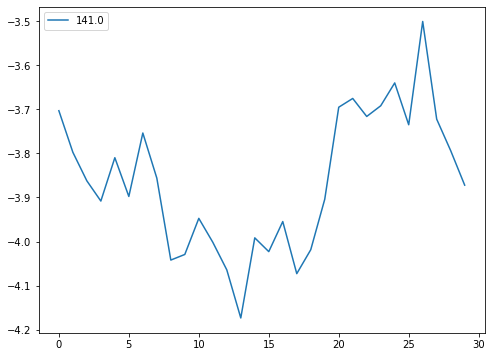

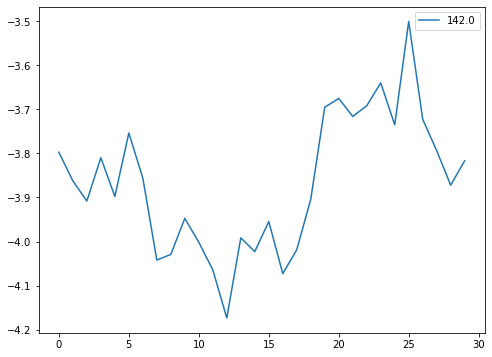

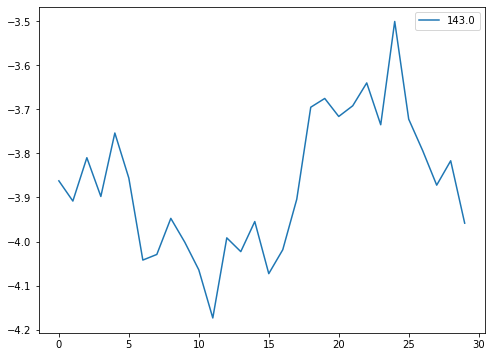

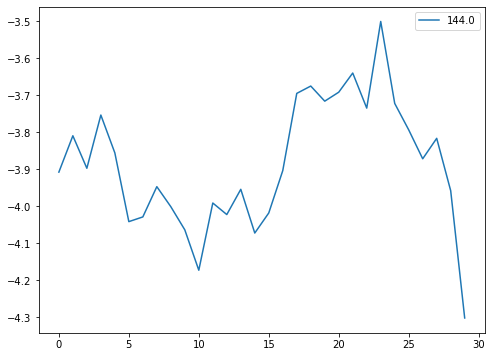

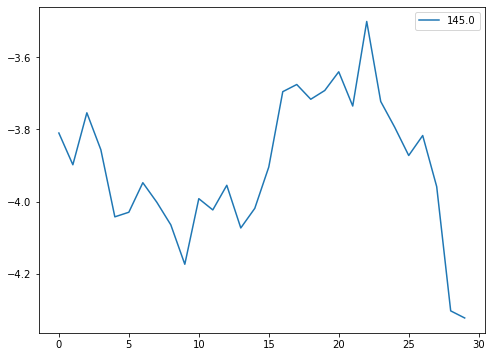

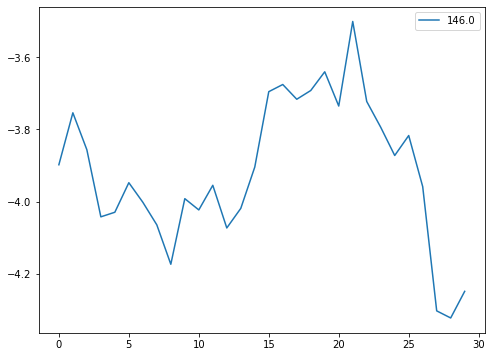

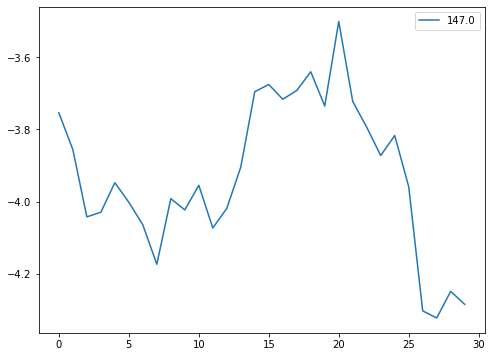

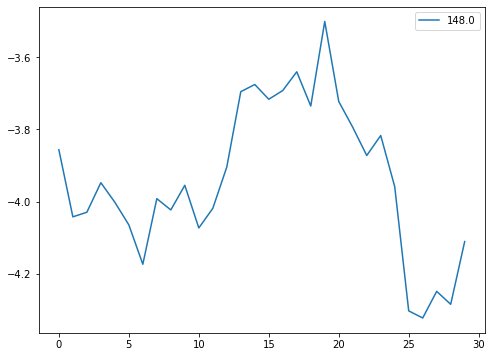

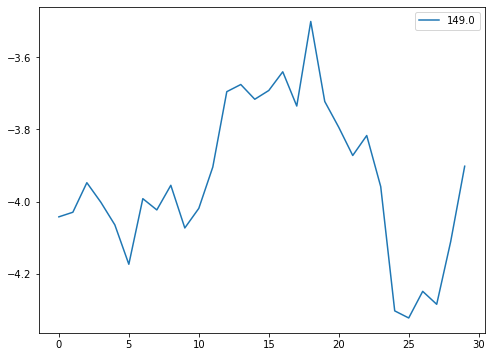

In [25]:
train_traj = wide_window.train.as_numpy_iterator()

for inputs,labels in train_traj:
    fig=pp.figure()
    ax=pp.axes()
    for i in range(inputs.shape[0]):
        ax.plot(inputs[i,:,0],label=labels[i,0,0])
    ax.legend(ncol=2)


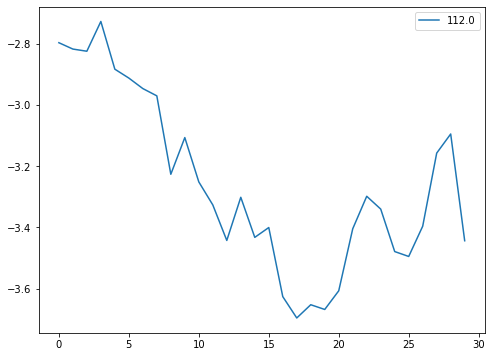

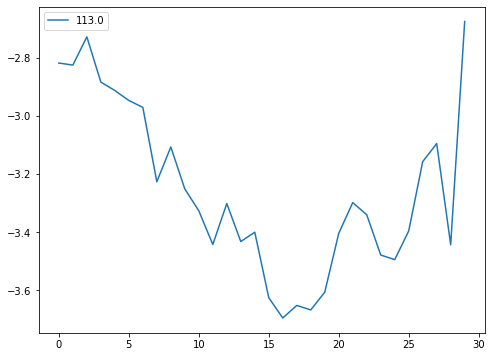

In [26]:
val_traj = wide_window.val.as_numpy_iterator()

for inputs,labels in val_traj:

    fig=pp.figure()
    ax=pp.axes()
    for i in range(inputs.shape[0]):
        ax.plot(inputs[i,:,0],label=labels[i,0,0])
    ax.legend(ncol=2)


### functions for model result plotting

In [31]:
def plotting(history):
    plt.plot(history.history['loss'], color = "red")
    plt.plot(history.history['val_loss'], color = "blue")
    red_patch = mpl.patches.Patch(color='red', label='Training')
    blue_patch = mpl.patches.Patch(color='blue', label='Test')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.show()

# store the model results for comparison
val_performance = {}
performance = {}


# the Long-Short Time Model

2/2 [==============================] - 0s 85ms/step - loss: 9458.5317 - mean_absolute_error: 97.2524


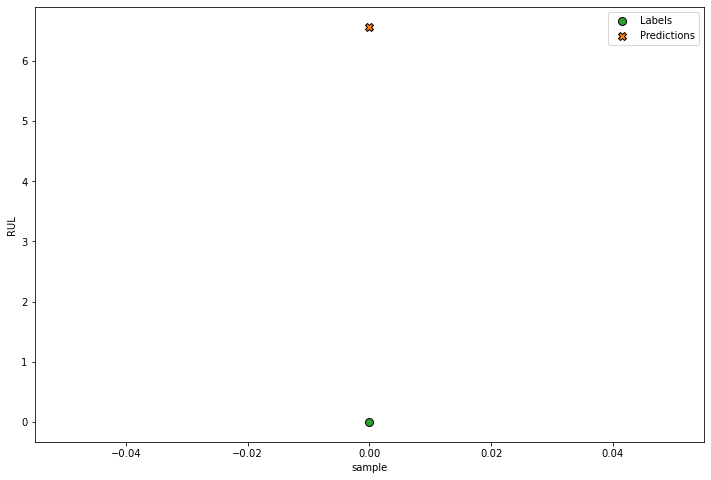

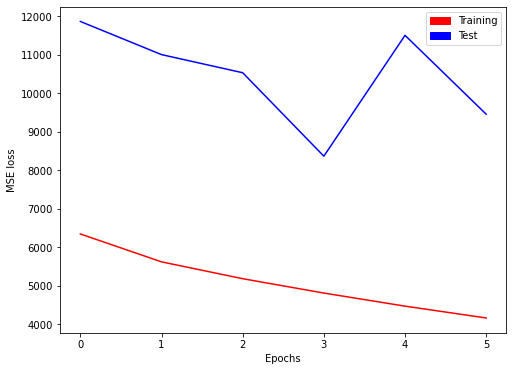

In [32]:
n_units=25
window_width=30
batch_size = 1

wide_window = WindowGenerator_RUL(
    input_width=window_width, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=batch_size)

wide_window

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(n_units, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

model_id = ('LSTM%dwin%d' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = lstm_model.evaluate(wide_window.val)
performance[model_id] = lstm_model.evaluate(wide_window.test, verbose=0)

wide_window.plot_RUL_RNN(lstm_model)
fig=pp.figure()
plotting(history)

# The statefull LSTM model

2/2 [==============================] - 0s 110ms/step - loss: 3096.0916 - mean_absolute_error: 55.6403


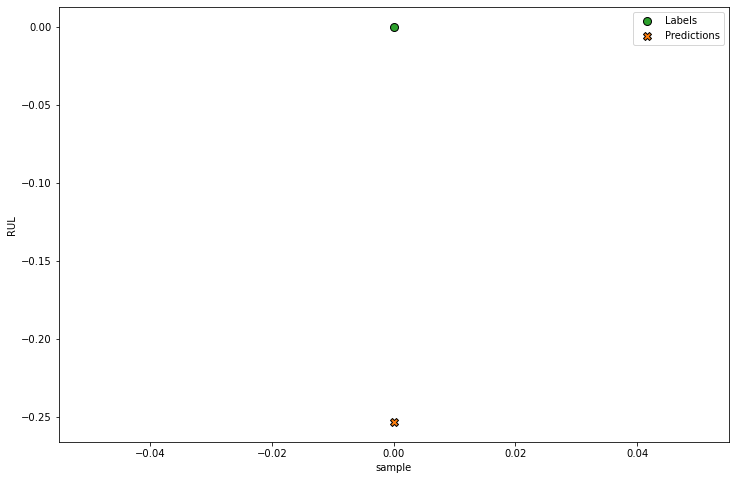

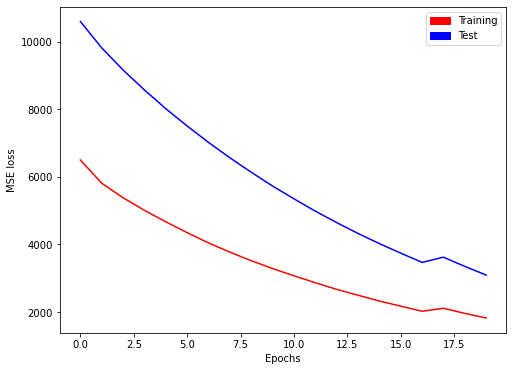

In [33]:
n_units=25
#window_width=30
dim_out=1
dim_in = 3
#batch_size = 1

wide_window = WindowGenerator_RUL(
    input_width=window_width, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=batch_size)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(batch_input_shape=(batch_size, None, dim_in),
               return_sequences=False, units=n_units, stateful=True))
#model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(activation='linear', units=dim_out)))
model.add(tf.keras.layers.Dense(activation='linear', units=dim_out))
model.compile(loss = 'mse', optimizer = 'rmsprop')
    

history = compile_and_fit(model, wide_window)

model_id = ('sfLSTM%dwin%d' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = model.evaluate(wide_window.val)
performance[model_id] = model.evaluate(wide_window.test, verbose=0)

wide_window.plot_RUL_RNN(model)
fig=pp.figure()
plotting(history)

# Try the GRU model

2/2 [==============================] - 0s 130ms/step - loss: 2713.7316 - mean_absolute_error: 52.0911


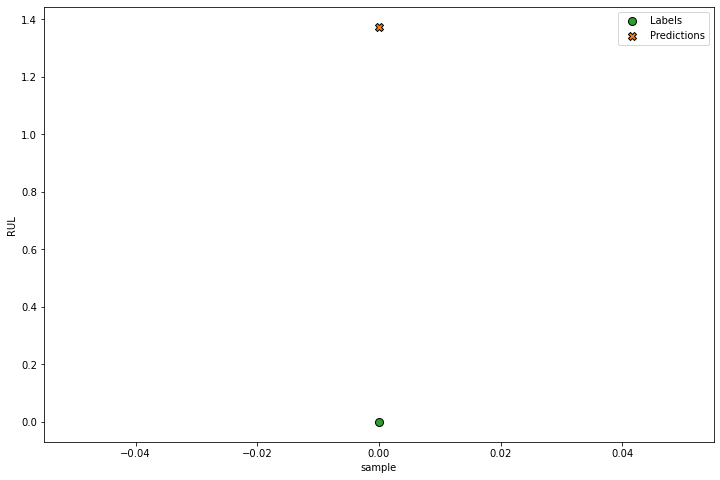

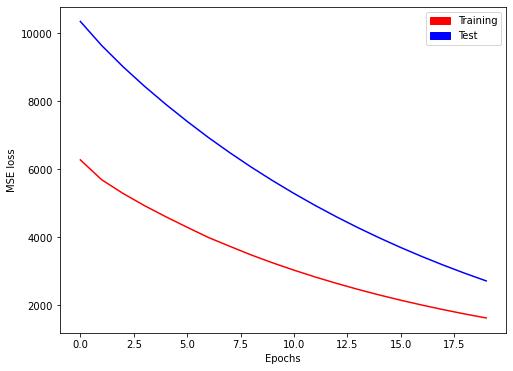

In [34]:
n_units=25
#window_width=30
#batch_size=1

model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(n_units, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(model, wide_window)

wide_window = WindowGenerator_RUL(
    input_width=window_width, 
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['RUL',],batch_size=batch_size)


model_id = ('GRU%dwin%d' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = model.evaluate(wide_window.val)
performance[model_id] = model.evaluate(wide_window.test, verbose=0)
wide_window.plot_RUL_RNN(model)
fig=pp.figure()
plotting(history)

Grub model performs better than the statefull LSTM

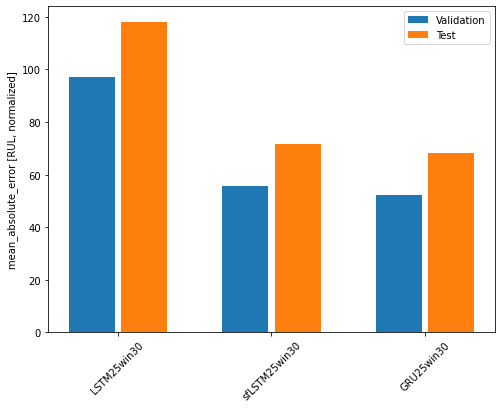

In [35]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [RUL, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


The GRU models are gives the best results. We will feed it with more data.

# compiling the data for the model input

# construct the data for feeding it in the model training

In [36]:
# separate the individual trajectories from train and test datasets into lists
# according to their fault mode
# fm ha meaing of the fault mode 

#    generate dictionaries by fault mode
test_by_fm = {} 
train_by_fm = {}

# data are all with the same fault mode fm=0

signals =  test_dataPD.loc[:,'pc1':].columns


for fm in [0,]:
    min_lenght = 1000
    for dataPD,data_by_fm  in zip([test_dataPD,train_dataPD] ,
                                                [test_by_fm,train_by_fm]):
        dataDict = {}
        for data_traj_idx in dataPD.index.get_level_values(level=0).unique():
            data_df = dataPD.loc[data_traj_idx,:]
            data_df = data_df.loc[:,signals]
            dataDict[data_traj_idx] = pd.DataFrame(index=data_df.index,
                                                  columns=data_df.columns,
                                                  data=data_df.values,dtype=np.float32)
            index_length = len(data_df.index.values)
            if index_length < min_lenght:
                min_lenght = index_length
        data_by_fm[fm] = dataDict
        print ('fault mode: %d, minimal trajectory length: %d' % (fm,min_lenght))

fault mode: 0, minimal trajectory length: 31
fault mode: 0, minimal trajectory length: 31


In [37]:
train_by_fm[0].keys() 

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

### send more data to the training agorithm

135/135 [==============================] - 0s 2ms/step - loss: 101.0669 - mean_absolute_error: 8.9497


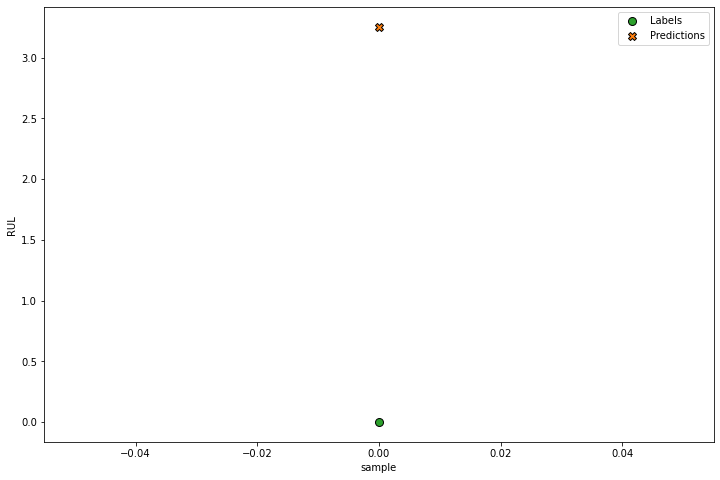

In [38]:
fm=0 # fault mode
n_units=25
window_width=31
batch_size=1

rnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(n_units, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])



train_keys_dict = {i : trajectory for i, trajectory in enumerate(list(train_by_fm[fm].keys()))}

while True:
    train_keys = list(train_keys_dict.keys())
    remaining = len(train_keys)
    if len(train_keys)==0:
        break
    random_trajectory_key = random.choice(train_keys)
    select_train_trajectory_idx = train_keys_dict.pop(random_trajectory_key)
    train_df = train_by_fm[fm][select_train_trajectory_idx] # use each training dataset only once   
    test_trajectory_idx = random.choice(list(test_by_fm[fm].keys()))
    val_trajectory_idx = random.choice(list(test_by_fm[fm].keys()))
    print ('training on trajectory: %d, remaining trajs: %d ' % \
           (select_train_trajectory_idx,len(train_keys)))
    
    wide_window = WindowGenerator_RUL(
        input_width=window_width, 
        train_df=train_df, 
        val_df=test_by_fm[fm][val_trajectory_idx], 
        test_df=test_by_fm[fm][test_trajectory_idx],
        label_columns=['RUL',],batch_size=batch_size)

    history = compile_and_fit(rnn_model, wide_window)



model_id = ('GRU%dwin%d_fully' % (n_units,window_width))
IPython.display.clear_output()
val_performance[model_id] = rnn_model.evaluate(wide_window.val)
performance[model_id] = rnn_model.evaluate(wide_window.test, verbose=0)
wide_window.plot_RUL_RNN(rnn_model)

In [39]:
rnn_model.save('models/%s_time_series_FD001_trained_FultMode%d-batch%d.h5' % (model_id, fm,batch_size))

### test the trained model on the test dataset:

In [40]:
fm=0 # fault mode

# Compare the RUL estimation  the test dataset
# the predicted value of the RUL will be the one from the first line of the first batch.

def get_prediction (model,test_df,window_width,batch_size=32):
    test_window = WindowGenerator_RUL(
        input_width=window_width, 
        train_df=test_df, 
        val_df=test_df, 
        test_df=test_df,
        label_columns=['RUL',],batch_size=batch_size)
    data = test_window.val.as_numpy_iterator()
    data = data.next()
    trueRUL = test_df.iloc[0,:].loc['RUL']
    predictions = model.predict(data[0])
    RUL_est = predictions[0][0]
    return ( trueRUL, RUL_est)



In [41]:
fm=0

testsDict = test_by_fm[fm]
trueRULs = []
RUL_ests = []
indexes = []
for idx, test_df in testsDict.items():
    print ('idx%d-len%d'%(idx,len(test_df.index)), end=' ')
    trueRUL, RUL_est = get_prediction (rnn_model,test_df,window_width=window_width,batch_size=batch_size)
    trueRULs.append(trueRUL)
    RUL_ests.append(RUL_est)
    indexes.append(idx)



idx1-len31 idx2-len49 idx3-len126 idx4-len106 idx5-len98 idx6-len105 idx7-len160 idx8-len166 idx9-len55 idx10-len192 idx11-len83 idx12-len217 idx13-len195 idx14-len46 idx15-len76 idx16-len113 idx17-len165 idx18-len133 idx19-len135 idx20-len184 idx21-len148 idx22-len39 idx23-len130 idx24-len186 idx25-len48 idx26-len76 idx27-len140 idx28-len158 idx29-len171 idx30-len143 idx31-len196 idx32-len145 idx33-len50 idx34-len203 idx35-len198 idx36-len126 idx37-len121 idx38-len125 idx39-len37 idx40-len133 idx41-len123 idx42-len156 idx43-len172 idx44-len54 idx45-len152 idx46-len146 idx47-len73 idx48-len78 idx49-len303 idx50-len74 idx51-len144 idx52-len189 idx53-len164 idx54-len121 idx55-len113 idx56-len136 idx57-len160 idx58-len176 idx59-len94 idx60-len147 idx61-len159 idx62-len232 idx63-len155 idx64-len168 idx65-len71 idx66-len147 idx67-len71 idx68-len187 idx69-len54 idx70-len152 idx71-len68 idx72-len131 idx73-len112 idx74-len137 idx75-len88 idx76-len205 idx77-len162 idx78-len72 idx79-len101 idx80

In [42]:
results = np.vstack([np.array(RUL_ests),np.array(trueRULs)]).T
columns = (model_id+('fm: %d' %fm),'ground_truth')
rnn_results_fm0 = pd.DataFrame(index=indexes,data=results,columns=columns)
#rnn_results_fm0.plot()

The estimations are quite well correlated with the ground truth values.

In [43]:
meta['GRU25_test_fit']= rnn_results_fm0.iloc[:,0]

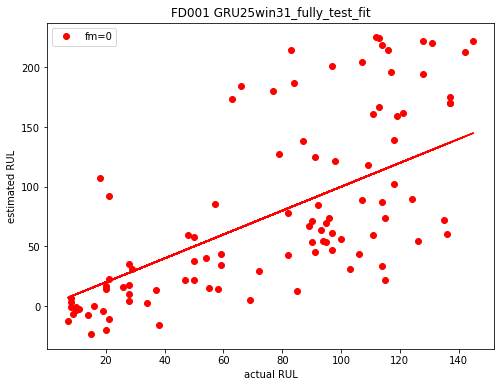

In [44]:
ax=pp.axes()
fm=0
pp.plot(RUL[meta['idx']].values,
            meta['GRU25_test_fit'].iloc[:].values,
            'ro',label='fm=%d'%fm)

pp.legend()
pp.xlabel('actual RUL')
pp.ylabel('estimated RUL')
pp.title(meta['Data Set Name']+ (' %s_test_fit' % model_id))
#ax.set_ylim([0,300])
ax.plot(RUL[meta['idx']].values,RUL[meta['idx']].values,'r-')

pp.savefig('models/GRU25_test_fit_FD001.png')

The Gated Recurrent Network (GRU) model yielded good correlation. The accuracy is not that high. Perhaps need to improve its training parameters procedure.

In [45]:
meta['GRU25_test_fit'].to_csv('models/GRU25_test_fit_FD001.csv')

In [46]:
truths = RUL[meta['idx']].values.flatten()
predicts = meta['GRU25_test_fit'].values.flatten()
RMSE = np.sqrt(mean_squared_error(truths,predicts))
R2 = r2_score(truths,predicts)

print ('dataset: %s, model: %s, RMSE = %.1f cycles, Rsquared = %.3f' % (meta['Data Set Name'],model_id,RMSE,R2))

dataset: FD001, model: GRU25win31_fully, RMSE = 54.3 cycles, Rsquared = 0.602
